### ECON 499 Data Preparation
   - By Sheldon Birkett

In [1]:
!pip install folium geopy
!pip install geojson
!pip install git+https://github.com/python-visualization/folium

  Cloning https://github.com/python-visualization/folium to c:\users\sheld\appdata\local\temp\pip-req-build-qgkf7r2l
  Created wheel for folium: filename=folium-0.0.0-py2.py3-none-any.whl size=95360 sha256=4438223c3e71d68e84bf522046ed1c8d3e961e0c0496c449107b9bfbfeb6d052
  Stored in directory: C:\Users\sheld\AppData\Local\Temp\pip-ephem-wheel-cache-ovqzgzbv\wheels\c7\41\34\51d4fc16546a2a77c5ca875d9232ebf13d902dd87615be512c
Successfully built folium


  Running command git clone -q https://github.com/python-visualization/folium 'C:\Users\sheld\AppData\Local\Temp\pip-req-build-qgkf7r2l'


In [2]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

'apt' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


  Cloning git://github.com/geopandas/geopandas.git to c:\users\sheld\appdata\local\temp\pip-req-build-ake6knyn
  Created wheel for geopandas: filename=geopandas-0.9.0+3.g8ddac2f-py2.py3-none-any.whl size=996245 sha256=79509562c98b28d7ddf446c0c2e46be9edc1444d30243b761880da3a1d387eb2
  Stored in directory: C:\Users\sheld\AppData\Local\Temp\pip-ephem-wheel-cache-gun64vgd\wheels\cf\3e\0b\6475054094c2b1ea054158ac1fdcf749fb92f5b512377e4cf8
Successfully built geopandas
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.8.0+98.gefea225
    Uninstalling geopandas-0.8.0+98.gefea225:
      Successfully uninstalled geopandas-0.8.0+98.gefea225


  Running command git clone -q git://github.com/geopandas/geopandas.git 'C:\Users\sheld\AppData\Local\Temp\pip-req-build-ake6knyn'


Wall time: 43.9 s


In [51]:
!pip install selenium

In [4]:
!pip install topojson

In [1]:
import folium
from folium.features import DivIcon
import geojson

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

In [4]:
import geopandas as gpd
from shapely import wkt
import shapely as sh
from shapely.geometry import box
from shapely import geometry

In [5]:
from itertools import chain

In [6]:
import topojson as tp

In [7]:
import branca.colormap as cm

In [8]:
from geopy.distance import great_circle as distance
from geopy.point import Point as Point
from math import sin, cos, atan2, sqrt, degrees, radians, pi

In [9]:
def import_csv(content):
    """Read in csv as a dataframe"""
    acs_data = pd.read_csv(content, encoding= 'unicode_escape')
    return acs_data

In [10]:
def midpoint(a, b):
    a_lat, a_lon = radians(a.latitude), radians(a.longitude)
    b_lat, b_lon = radians(b.latitude), radians(b.longitude)
    delta_lon = b_lon - a_lon
    B_x = cos(b_lat) * cos(delta_lon)
    B_y = cos(b_lat) * sin(delta_lon)
    mid_lat = atan2(
        sin(a_lat) + sin(b_lat),
        sqrt(((cos(a_lat) + B_x) ** 2 + B_y ** 2))
    )
    mid_lon = a_lon + atan2(B_y, cos(a_lat) + B_x)
    # Normalise
    mid_lon = (mid_lon + 3 * pi) % (2 * pi) - pi

    return Point(latitude=degrees(mid_lat), longitude=degrees(mid_lon))

In [11]:
def get_line_midpoint(line):
    a = Point(line[0])
    b = Point(line[1])

    return midpoint(a,b)

In [12]:
def calculate_dist_to_line(line_a_lat, line_a_lng, line_b_lat, line_b_lng, point_object):
    a = Point(latitude=line_a_lat, longitude=line_a_lng)
    b = Point(latitude=line_b_lat, longitude=line_b_lng)
    dist = distance(midpoint(a, b), point_object)
    return dist

In [13]:
def get_min_distance_to_arr(arr_coords, point_object, unit='m'):
    min_dist = 999999
    line=[]
    for i, _ in enumerate(arr_coords):
        if i + 1 < len(arr_coords):
            dist = calculate_dist_to_line(
                line_a_lat=arr_coords[i][1],
                line_a_lng=arr_coords[i][0],
                line_b_lat=arr_coords[i + 1][1],
                line_b_lng=arr_coords[i + 1][0],
                point_object=point_object
            )
            if dist < min_dist:
                min_dist = dist
                line = [(arr_coords[i][1], arr_coords[i][0]), (arr_coords[i + 1][1], arr_coords[i + 1][0])]
        else:
            dist = calculate_dist_to_line(
                line_a_lat=arr_coords[i][1],
                line_a_lng=arr_coords[i][0],
                line_b_lat=arr_coords[0][1],
                line_b_lng=arr_coords[0][0],
                point_object=point_object
            )
            if dist < min_dist:
                min_dist = dist
                line = [(arr_coords[i][1], arr_coords[i][0]), (arr_coords[0][1], arr_coords[0][0])]

    if unit == 'm':
        return min_dist.m, line
    elif unit == 'km':
        return min_dist.km, line
    else:
        return min_dist, line

In [14]:
def to_coords(multipolygon):
    for polygon in multipolygon:
        yield from polygon.exterior.coords[:-1]
        yield from chain.from_iterable(interior.coords[:-1] for interior in polygon.interiors)

In [15]:
def strip_dict_keys_values(d):
    """To remove white-space in keys and values in dictionary"""
    def strip_list(l):
        return [strip_dict_keys_values(x)
                if isinstance(x, dict) else strip_list(x)
                if isinstance(x, list) else clean(x) for x in l]

    def clean(value):
        if isinstance(value, str):
            return value.strip()
        return value

    return {key.strip(): strip_dict_keys_values(value)
            if isinstance(value, dict) else strip_list(value)
            if isinstance(value, list) else clean(value)
            if value is None else clean(value)
            for key, value in d.items()}

In [16]:
def reversed_colormap(existing):
    return cm.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax)

In [17]:
#get coords for polygon and multipolygon as previous get coord function only worked on polygons. 
def get_coords_from_polygon(shape):
    coords = set()

    if isinstance(shape, sh.geometry.Polygon):
        coords.update(shape.exterior.coords[:-1])
        for linearring in shape.interiors:
            coords.update(linearring.coords[:-1])
    elif isinstance(shape, sh.geometry.MultiPolygon):
        for polygon in shape:
            coords.update(get_coords_from_polygon(polygon))

    return list(coords)

### Import Wildfire Perimeter Data, To GeoJSON file

In [18]:
wildfire_perimeters = gpd.read_file(r"C:\Users\sheld\Downloads\THESIS_MAPS_\Historic_GeoMAC_Perimeters_Combined_2000-2018-shp")
#wildfire_perimeters.to_file('wildfire_perimeters.geojson', driver='GeoJSON')

### Sorting Out Map Style and Layout/Look

In [17]:
# wildfire_perimeters_2015 = wildfire_perimeters[wildfire_perimeters["fireyear"] == 2015]
# Test_fire = wildfire_perimeters_2015[(wildfire_perimeters_2015["incidentna"]== "Rough") | (wildfire_perimeters_2015["incidentna"]=="Valley") | (wildfire_perimeters_2015["incidentna"]=="River Complex")| (wildfire_perimeters_2015["incidentna"]=="Made River Complex")| (wildfire_perimeters_2015["incidentna"]=="Butte")]

In [18]:
# poi_name = 'Trinity County Blk 1'
# poi = [41.0171618, -122.6402253] #Lat, Long 

In [19]:
# # Map it
# m = folium.Map(location=poi, zoom_start=9, tiles='https://api.mapbox.com/styles/v1/sheldonnb/ckkz0oxri7j6w1ap5zcwzgu8m/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoic2hlbGRvbm5iIiwiYSI6ImNra3owZzB5ajBidDQycHBsZGY1Zm1vYnAifQ.IiKmYf729J6mYBynizPi2g', attr = 'XXX Mapbox Attribution')
# # Display Wildfire Perimeters
# folium.GeoJson(data = Test_fire["geometry"], name="geojson").add_to(m)

# # Display POI
# folium.Marker(location=poi,popup="<b>Block Group 1, Census Tract 1.01,Trinity County</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)


In [20]:
#m #produce map of single poi and wildfire perimeter

Find Min Distance to a Fire Perimeter for One Point

In [21]:
# points = list(to_coords(Test_fire["geometry"].iloc[1]))

In [22]:
# coords = points

In [23]:
# p = Point(latitude=poi[0],longitude=poi[1])

In [24]:
# dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
# line_midpoint = get_line_midpoint(line)

In [25]:
# m = folium.Map(location=poi, zoom_start=12, tiles='CartoDB dark_matter')


# # Display POI
# folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
# # Display POI Name
# folium.map.Marker(location=poi, icon=DivIcon(
#     icon_size=(150, 36),
#     icon_anchor=(0, 0),
#     html='<div style="font-size: 18pt; color: red">{}</div>'.format(poi_name)
# )).add_to(m)

# for i, _ in enumerate(coords):
#     if i+1 < len(coords):
#         folium.PolyLine(locations=[(coords[i][1],coords[i][0]),(coords[i+1][1],coords[i+1][0])], color='blue').add_to(m)
#     else:
#         folium.PolyLine(locations=[(coords[i][1], coords[i][0]), (coords[0][1], coords[0][0])],
#                         color='blue').add_to(m)

# folium.PolyLine(locations=line, color='red').add_to(m)
# folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='red').add_to(m)
# folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

# new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
# folium.map.Marker(location=[new_line_mp.latitude,new_line_mp.longitude], icon=DivIcon(
#     icon_size=(150, 36),
#     icon_anchor=(0, 0),
#     html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
# )).add_to(m)

In [26]:
#m #displays min dist to polygon

Find the Min Distance for Many Wildfire Perimeters

In [27]:
# m = folium.Map(location=poi, zoom_start=12, tiles='CartoDB dark_matter')

# # Display POI
# folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
# # Display POI Name
# folium.map.Marker(location=poi, icon=DivIcon(
#     icon_size=(150, 36),
#     icon_anchor=(0, 0),
#     html='<div style="font-size: 18pt; color: red">{}</div>'.format(poi_name)
# )).add_to(m)

# # Display Arrondissements
# folium.GeoJson(Test_fire).add_to(m) #Note change to Test_fire for example
# Display Arrondissements Numbers
# for arrond in data['features']:
#     loc = arrond['properties']['geom_x_y']
#     nr = arrond['properties']['c_ar']
#     folium.map.Marker(location=loc, icon=DivIcon(
#         icon_size=(150, 36),
#         icon_anchor=(0, 0),
#         html='<div style="font-size: 15pt; color:rgb(41,111,255)">{}</div>'.format(str(nr))
#     )).add_to(m)

# for arrond in data['features']:

#     coords = arrond['geometry']['coordinates'][0]
#     p = Point(latitude=poi[0],longitude=poi[1])
#     dist, line = fu.get_min_distance_to_arr(arr_coords=coords,point_object=p)
#     line_midpoint = fu.get_line_midpoint(line)

    # for i, _ in enumerate(coords):
    #     if i+1 < len(coords):
    #         folium.PolyLine(locations=[(coords[i][1],coords[i][0]),(coords[i+1][1],coords[i+1][0])], color='blue').add_to(m)
    #     else:
    #         folium.PolyLine(locations=[(coords[i][1], coords[i][0]), (coords[0][1], coords[0][0])],
    #                         color='blue').add_to(m)

    # folium.PolyLine(locations=line, color='red').add_to(m)
    # folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='red').add_to(m)
    # folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

    # new_line_mp = fu.get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
    # folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
    #     icon_size=(150, 36),
    #     icon_anchor=(0, 0),
    #     html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
    # )).add_to(m)

In [28]:
#m #plotted a few wildfire perimeters and a signle poi

In [29]:
# points = []
# for i in range(len(Test_fire["geometry"])): 
#   points.append(list(to_coords(Test_fire["geometry"].iloc[i]))) #gives list of list of coords for each wildfire perimeter

In [30]:
# distances = []
# for i in range(len(points)):
#   coords = points[i]
#   p = Point(latitude=poi[0],longitude=poi[1])
#   dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#   line_midpoint = get_line_midpoint(line)

#   distances.append(dist) 

#   folium.PolyLine(locations=line, color='red').add_to(m)
#   folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='red').add_to(m)
#   folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

#   new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
#   folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
#         icon_size=(150, 36),
#         icon_anchor=(0, 0),
#         html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
#     )).add_to(m)

In [31]:
#m #shows plot of minimum distance to single poi and a few perimeters with min dist in meters

### Now Calculate Min Distances to Wildfires for Multiple Homes/POI's - 2010 Block Groups ``ACS5_2009_bg``

In [32]:
#ACS5_2014_bg0 = import_csv(r"C:\Users\sheld\Documents\Thesis_Data_Full_United_States\merged_data_with_block_groups\ACS5_2014_bg.csv")
ACS5_2009_bg0 = import_csv(r"C:\Users\sheld\Documents\Thesis_Data_Full_United_States\merged_data_with_block_groups\ACS5_2009_bg.csv")
#2010 block groups

In [33]:
#ACS5_2014_bg0["POIs"] = list(zip(ACS5_2014_bg0.INTPTLAT, ACS5_2014_bg0.INTPTLON)) #coordinates for homes/center of block groups
ACS5_2009_bg0["POIs"] = list(zip(ACS5_2009_bg0.INTPTLAT10, ACS5_2009_bg0.INTPTLON10))

missing house prices for 8532 homes, will drop. 

In [33]:
#missing = ACS5_2014_bg0.loc[ACS5_2014_bg0["ABITE001"].isnull()].index.tolist() #missing median home prices for 8532 observations
#ACS5_2014_bg0 = ACS5_2014_bg0.drop(missing).reset_index()

In [35]:
missing = ACS5_2009_bg0.loc[ACS5_2009_bg0["RR7M001"].isnull()].index.tolist() #missing median home prices
ACS5_2009_bg0 = ACS5_2009_bg0.drop(missing).reset_index()

### More Testing With Graphs

In [36]:
# West_US = [40.117651, -115.158374] #random location in middle of western united states. a

In [37]:
# ACS5_2014_Test = ACS5_2014_bg0.iloc[::2000, :].drop(columns = ["Unnamed: 0"]).reset_index() #select every 2000th row just as a sample.

In [38]:
#my_tile = 'https://api.mapbox.com/styles/v1/sheldonnb/ckkz0oxri7j6w1ap5zcwzgu8m/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoic2hlbGRvbm5iIiwiYSI6ImNra3owZzB5ajBidDQycHBsZGY1Zm1vYnAifQ.IiKmYf729J6mYBynizPi2g'
my_tile = 'https://api.mapbox.com/styles/v1/sheldonnb/cklub39iz38pr17mgn9xran5i/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoic2hlbGRvbm5iIiwiYSI6ImNra3owZzB5ajBidDQycHBsZGY1Zm1vYnAifQ.IiKmYf729J6mYBynizPi2g'

In [39]:
# m = folium.Map(location=West_US, zoom_start=12, tiles= my_tile, attr = 'XXX Mapbox Attribution')

# # Display Wildfires
# folium.GeoJson(Test_fire).add_to(m) #Note change to Test_fire for example

# min_distances = []
# points = []
# for i in range(len(Test_fire["geometry"])): 
#     points.append(list(to_coords(Test_fire["geometry"].iloc[i]))) #gives list of list of coords for each wildfire perimeter

# for j in range(len(ACS5_2014_Test["POIs"])): 
#     # Display POI for center of block group i.
#     poi = ACS5_2014_Test["POIs"][j] 
#     #folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
#     pop = ACS5_2014_Test["NAME_E"][j]
#     folium.Marker(location=poi,popup=f"<b>{pop}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)
#     # Display POI Name
#     # folium.map.Marker(location=poi, icon=DivIcon(
#     #     icon_size=(150, 36),
#     #     icon_anchor=(0, 0),
#     #     html='<div style="font-size: 18pt; color: red">{}</div>'.format(poi_name)
#     # )).add_to(m)
#     distances = []
#     lines = []
#     for i in range(len(points)):
#         coords = points[i]
#         p = Point(latitude=poi[0],longitude=poi[1])
#         dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#         line_midpoint = get_line_midpoint(line)
#         distances.append(dist)
#         lines.append(line)
#         folium.PolyLine(locations=line, color='#AD44DA').add_to(m)
#         folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='#AD44DA').add_to(m)
#         folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)
        
#         new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
#         folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
#               icon_size=(150, 36),
#               icon_anchor=(0, 0),
#               html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
#           )).add_to(m)
        
#     min_distances.append(min(distances))

In [40]:
#m.save('distance_map.html') #produce map of many minimum distances from many poi's to many wildfire perimeters

## Produce Map of All Wildfire from 2010 to 2018

In [41]:
# ACS5_2010_2014_POIs = ACS5_2014_bg0[ACS5_2014_bg0["YEAR"]=="2010-2014"].copy()
# ACS5_2010_2014_POIs = ACS5_2010_2014_POIs[(ACS5_2010_2014_POIs["STATE"] == "Arizona") | (ACS5_2010_2014_POIs["STATE"] == "California")|(ACS5_2010_2014_POIs["STATE"] == "Colorado") | (ACS5_2010_2014_POIs["STATE"] == "Idaho")|(ACS5_2010_2014_POIs["STATE"] == "Nebraska")| (ACS5_2010_2014_POIs["STATE"] == "New Mexico")|(ACS5_2010_2014_POIs["STATE"] == "Oklahoma")| (ACS5_2010_2014_POIs["STATE"] == "Oregon")|(ACS5_2010_2014_POIs["STATE"] == "South Dakota")|(ACS5_2010_2014_POIs["STATE"] == "Texas")|(ACS5_2010_2014_POIs["STATE"] == "Kansas")| (ACS5_2010_2014_POIs["STATE"] == "Wyoming")|(ACS5_2010_2014_POIs["STATE"] == "Montana")|(ACS5_2010_2014_POIs["STATE"] == "North Dakota")|(ACS5_2010_2014_POIs["STATE"] == "Utah")|(ACS5_2010_2014_POIs["STATE"] == "Nevada")| (ACS5_2010_2014_POIs["STATE"] == "Washington")].reset_index()

In [ ]:
#only for larger map
#ACS5_2010_2014_POIs = ACS5_2010_2014_POIs.iloc[::2, :].drop(columns = ["Unnamed: 0", "level_0"]).reset_index() #select every 2nd row 

In [42]:
#sTate = wildfire_perimeters.groupby(["state"])

In [43]:
wildfire_perimeters = wildfire_perimeters[(wildfire_perimeters["state"]== "CA")| (wildfire_perimeters["state"]=="AZ")| (wildfire_perimeters["state"]=="CO")|(wildfire_perimeters["state"]=="ID")|(wildfire_perimeters["state"]=="NE")|(wildfire_perimeters["state"]=="NM")|(wildfire_perimeters["state"]=="OK")|(wildfire_perimeters["state"]=="OR")|(wildfire_perimeters["state"]=="SD")|(wildfire_perimeters["state"]=="TX")|(wildfire_perimeters["state"]=="KS")|(wildfire_perimeters["state"]=="WY")|(wildfire_perimeters["state"]=="MT")|(wildfire_perimeters["state"]=="ND")|(wildfire_perimeters["state"]=="UT")|(wildfire_perimeters["state"]=="NV")|(wildfire_perimeters["state"]=="WA")]

In [44]:
#get fire years of interest which covers acs 2010-2019 dataframes
fire_years = list(range(2005,2019))
frames = []
for i in range(len(fire_years)):
    wildfires = wildfire_perimeters[wildfire_perimeters["fireyear"] == fire_years[i]]
    frames.append(wildfires)

wildfires_2005_to_2018 = pd.concat(frames,join='inner', ignore_index=True) #changed this for 2005-2009 was 2015-2018 (i.e.2010-2018)

In [46]:
# fire_min = wildfires_2015_to_2018['gisacres'].min()
# fire_max = wildfires_2015_to_2018['gisacres'].max()

# #linear = cm.linear.OrRd_05.scale(fire_min, fire_max) #old OrRd_05, Reds_09
# linear = cm.LinearColormap(colors=['#ffa64d','#cc0000'],vmin=fire_min,vmax=fire_max)

In [134]:
# house_price_min = ACS5_2010_2014_POIs["ABITE001"].min()
# house_price_max = ACS5_2010_2014_POIs["ABITE001"].max()

# #linear_house = cm.linear.GnBu_09.scale(house_price_min+3000, house_price_max) #BuGn_05 old colour scale
# linear_house = cm.LinearColormap(colors=['#b3d9ff','#1a1aff'],vmin=house_price_min,vmax=house_price_max)
# #linear_house = reversed_colormap(linear_house)

# #linear = reversed_colormap(linear)

In [57]:
# print(house_price_min)
# print(house_price_max)

In [47]:
# m = folium.Map(location=[38.5, -113.158374], zoom_start=5.49, tiles= my_tile, attr = 'XXX Mapbox Attribution', prefer_canvas=True)

# title_html = '''
#              <h3 align="center" style="font-size:20px"><b>Wildfires 2010-2018 and Median Property Values by Block Group</b></h3>
#              '''
# m.get_root().html.add_child(folium.Element(title_html))

# houses = list(ACS5_2010_2014_POIs["ABITE001"])

# for j in range(len(ACS5_2010_2014_POIs["POIs"])):
#     poi = ACS5_2010_2014_POIs["POIs"][j]
        
#     map_colours_2 = linear_house(houses[j])
#     folium.CircleMarker(location=poi, color= map_colours_2, radius=0.000001, fill= map_colours_2).add_to(m)
    
# linear_house = linear_house.to_step(index=[0, 100_000, 300_000, 500_000, 700_000, 900_000])
# linear_house.caption = 'Median House Prices 2019 Dollars'
# linear_house.add_to(m)
    
# map_colors = lambda x: {
#     'fillColor': linear(x['properties']['gisacres']),
#     'color': 'black',
#     'weight': 0.25,
#     'fillOpacity': 0.5
# }
    
# #Display Wildfires
# folium.GeoJson(
#     wildfires_2015_to_2018,
#     name = 'Wildfires',
#     style_function = map_colors
# ).add_to(m)
    
# folium.LayerControl(collapsed = True).add_to(m)

# linear = linear.to_step(index=[0, 100_000, 200_000, 300_000, 400_000, 500_000, 700_000])
# linear.caption = 'Number of Acres Burned by Wildfire'
# linear.add_to(m)

In [48]:
# m.save('map_of_all_fires_newTile_3.html')

### Map for California

In [22]:
# wildfire_perimetersCA = wildfire_perimeters[(wildfire_perimeters["state"]== "CA")|(wildfire_perimeters["state"]== "AZ")|(wildfire_perimeters["state"]=="NV")|(wildfire_perimeters["state"]=="OR")]
# ACS5_2010_2014_POIsCA = ACS5_2010_2014_POIs[(ACS5_2010_2014_POIs["STATE"] == "Arizona") | (ACS5_2010_2014_POIs["STATE"] == "California")| (ACS5_2010_2014_POIs["STATE"] == "Oregon")|(ACS5_2010_2014_POIs["STATE"] == "Nevada")].drop(columns = ["level_0"]).reset_index()

In [23]:
# #get fire years of interest which covers acs 2010-2019 dataframes for california 
# fire_years = list(range(2010,2019))
# frames = []
# for i in range(len(fire_years)):
#     wildfires = wildfire_perimetersCA[wildfire_perimetersCA["fireyear"] == fire_years[i]]
#     frames.append(wildfires)

# wildfires_2015_to_2018 = pd.concat(frames,join='inner', ignore_index=True)

In [50]:
# fire_min = wildfires_2015_to_2018['gisacres'].min()
# fire_max = wildfires_2015_to_2018['gisacres'].max()

# #linear = cm.linear.OrRd_05.scale(fire_min, fire_max) #old OrRd_05, Reds_09
# linear = cm.LinearColormap(colors=['#ffa64d','#cc0000'],vmin=fire_min,vmax=fire_max)

# house_price_min = ACS5_2010_2014_POIsCA["ABITE001"].min()
# house_price_max = ACS5_2010_2014_POIsCA["ABITE001"].max()

# #linear_house = cm.linear.GnBu_09.scale(house_price_min+3000, house_price_max) #BuGn_05 old colour scale
# linear_house = cm.LinearColormap(colors=['#b3d9ff','#1a1aff'],vmin=house_price_min,vmax=house_price_max)
# #linear_house = reversed_colormap(linear_house)

# #linear = reversed_colormap(linear)

In [51]:
# m = folium.Map(location=[37.4783, -120.4179], zoom_start=6.7, control_scale=True, tiles= my_tile, attr = 'XXX Mapbox Attribution', prefer_canvas=True)
# # Display Wildfire Perimeters

# title_html = '''
#              <h3 align="center" style="font-size:20px"><b>Central California Wildfires 2010-2018 and Median Property Values by Block Group</b></h3>
#              '''
# m.get_root().html.add_child(folium.Element(title_html))


# linear_house = linear_house.to_step(index=[0, 100_000, 300_000, 500_000, 700_000, 900_000])
# linear_house.caption = 'Median House Prices 2019 Dollars'
# linear_house.add_to(m)

# linear = linear.to_step(index=[0, 100_000, 200_000, 300_000, 400_000, 500_000, 700_000])
# linear.caption = 'Number of Acres Burned by Wildfire'
# linear.add_to(m)

# m.scale.add_to(m)

# m

In [52]:
# m.save("test_map.html")

In [53]:
# m = folium.Map(location=[37.4783, -120.4179], zoom_start=6.7, tiles= my_tile, attr = 'XXX Mapbox Attribution', prefer_canvas=True, control_scale = True)

# title_html = '''
#              <h3 align="center" style="font-size:20px"><b>Central California Wildfires 2010-2018 and Median Property Values by Block Group</b></h3>
#              '''
# m.get_root().html.add_child(folium.Element(title_html))

# #fire_dict = dict(zip(wildfires_2015_to_2018['incidentna'], wildfires_2015_to_2018['gisacres']))

# houses = list(ACS5_2010_2014_POIsCA["ABITE001"])

# for j in range(len(ACS5_2010_2014_POIsCA["POIs"])):
#     poi = ACS5_2010_2014_POIsCA["POIs"][j]
        
#     map_colours_2 = linear_house(houses[j])
#     folium.CircleMarker(location=poi, color= map_colours_2, radius=0.000001, fill= map_colours_2).add_to(m)
    
# linear_house = linear_house.to_step(index=[0, 100_000, 300_000, 500_000, 700_000, 900_000])
# linear_house.caption = 'Median House Prices 2019 Dollars'
# linear_house.add_to(m)
    
# map_colors = lambda x: {
#     'fillColor': linear(x['properties']['gisacres']),
#     'color': 'black',
#     'weight': 0.25,
#     'fillOpacity': 0.5
# }
    
# #Display Wildfires
# folium.GeoJson(
#     wildfires_2015_to_2018,
#     name = 'Wildfires',
#     style_function = map_colors
# ).add_to(m)

# folium.LayerControl(collapsed = True).add_to(m)

# linear = linear.to_step(index=[0, 100_000, 200_000, 300_000, 400_000, 500_000, 700_000])
# linear.caption = 'Number of Acres Burned by Wildfire'
# linear.add_to(m)



In [54]:
#m.save('central_map_california.html')

In [55]:
#buffer = wildfires_2015_to_2018.geometry.buffer()

## Create Map of All Wildfire Perimeters - Box Map

In [42]:
# h = wildfires_2015_to_2018["geometry"][7]
# h

In [43]:
# b = h.bounds

In [44]:
# b

In [45]:
# bb = box(-146.35855885399997, 64.76123059500003, -146.22002814499996, 64.82435905700004)

In [46]:
# bb

In [49]:
boun = []
for i in range(len(wildfires_2005_to_2018 ["geometry"])):
    l = wildfires_2005_to_2018["geometry"][i].bounds
    boun.append(l)

In [51]:
box_list = []
for i in range(len(boun)):
    a = boun[i][0]
    b = boun[i][1]
    c = boun[i][2]
    d = boun[i][3]
    m = box(a,b,c,d)
    box_list.append(geometry.Polygon(list(m.exterior.coords)))

In [52]:
#wildfires_2015_to_2018["boxgeo"] = box_list
wildfires_2005_to_2018["boxgeo"] = box_list

In [53]:
#wildfires_2015_to_2018_box_geo = wildfires_2015_to_2018[["boxgeo","gisacres","fireyear","state"]]
wildfires_2005_to_2018_box_geo = wildfires_2005_to_2018[["boxgeo","gisacres","fireyear","state"]]

In [54]:
#wildfires_2015_to_2018_box_geo = gpd.GeoDataFrame(wildfires_2015_to_2018_box_geo, geometry='boxgeo')
wildfires_2005_to_2018_box_geo = gpd.GeoDataFrame(wildfires_2005_to_2018_box_geo, geometry='boxgeo')


#wildfires_2015_to_2018_box_geo.to_file('wildfires_2015_to_2018_box_geo.geojson', driver='GeoJSON')

In [55]:
# wildfires_2015_to_2018_box_geo = wildfires_2015_to_2018_box_geo.set_crs("EPSG:4326") #set projection. 
# wildfires_2015_to_2018_box_geo = wildfires_2015_to_2018_box_geo.set_crs(epsg=4326)

wildfires_2005_to_2018_box_geo = wildfires_2005_to_2018_box_geo.set_crs("EPSG:4326") #set projection. 
wildfires_2005_to_2018_box_geo = wildfires_2005_to_2018_box_geo.set_crs(epsg=4326)

In [65]:
fire_min = wildfires_2005_to_2018['gisacres'].min()
fire_max = wildfires_2005_to_2018['gisacres'].max()

#linear = cm.linear.OrRd_05.scale(fire_min, fire_max) #old OrRd_05, Reds_09
linear = cm.LinearColormap(colors=['#ffa64d','#cc0000'],vmin=fire_min,vmax=fire_max)

In [66]:
m = folium.Map(location=[38.5, -113.158374], zoom_start=5.49, tiles= my_tile, attr = 'XXX Mapbox Attribution', prefer_canvas=True)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>United States Wildfires 2005-2018</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))


#fire_dict = dict(zip(wildfires_2015_to_2018['incidentna'], wildfires_2015_to_2018['gisacres']))
    
map_colors = lambda x: {
    'fillColor': linear(x['properties']['gisacres']),
    'color': 'black',
    'weight': 0.25,
    'fillOpacity': 0.5
}
    
#Display Wildfires
folium.GeoJson(
    wildfires_2005_to_2018_box_geo,
    name = 'Wildfires',
    style_function = map_colors
).add_to(m)

folium.LayerControl(collapsed = True).add_to(m)

linear = linear.to_step(index=[0, 100_000, 200_000, 300_000, 400_000, 500_000, 700000])
linear.caption = 'Number of Acres Burned by Wildfire'
linear.add_to(m)

In [67]:
m.save('boxgeo2005_2018.html')

test getting minimum distances for simplified shapes (squares/rectangles)

In [18]:
#ACS5_2014_WEST = ACS5_2014_bg0[(ACS5_2014_bg0["STATE"] == "Arizona") | (ACS5_2014_bg0["STATE"] == "California")|(ACS5_2014_bg0["STATE"] == "Colorado") | (ACS5_2014_bg0["STATE"] == "Idaho")|(ACS5_2014_bg0["STATE"] == "Nebraska")| (ACS5_2014_bg0["STATE"] == "New Mexico")|(ACS5_2014_bg0["STATE"] == "Oklahoma")| (ACS5_2014_bg0["STATE"] == "Oregon")|(ACS5_2014_bg0["STATE"] == "South Dakota")|(ACS5_2014_bg0["STATE"] == "Texas")|(ACS5_2014_bg0["STATE"] == "Kansas")| (ACS5_2014_bg0["STATE"] == "Wyoming")|(ACS5_2014_bg0["STATE"] == "Montana")|(ACS5_2014_bg0["STATE"] == "North Dakota")|(ACS5_2014_bg0["STATE"] == "Utah")|(ACS5_2014_bg0["STATE"] == "Nevada")| (ACS5_2014_bg0["STATE"] == "Washington")]

In [20]:
#ACS5_2014_WEST = ACS5_2014_WEST.drop(columns=["Unnamed: 0"]).reset_index()

In [95]:
#wildfires_2015_box_geo = wildfires_2015_to_2018_box_geo[wildfires_2015_to_2018_box_geo["fireyear"] == 2015]

In [99]:
# %%time
# ## Min Distance Calculation for Wildfire Year 2015. 

# ##m = folium.Map(location=West_US, zoom_start=8, tiles='Stamen Terrain') # double "##" is older code not used in loop distance calculation

# ##Display Wildfires
# ##folium.GeoJson(wildfire_perimeters_2015).add_to(m) #Note change to Test_fire for example

# min_distances = []
# points = []
# #make all the lists for each state you will look at
# for i in range(len(wildfires_2015_box_geo["boxgeo"])):
#   ##poly = wildfire_perimeters_2015["geometry"].iloc[i]
#   ##if poly.geom_type == 'MultiPolygon':
#   ##   points.append(list(to_coords(wildfire_perimeters_2015["geometry"].iloc[i]))) #gives list of list of coords for each wildfire perimeter Multipolygon
#   ##elif poly.geom_type == 'Polygon':
#     #if fire in california append to california list else if fire in texas append to texas list etc etc
#     points.append(get_coords_from_polygon(wildfires_2015_box_geo["boxgeo"].iloc[i])) #gives list of list of coords for each wildfire perimeter Polygon

# for j in range(len(ACS5_2014_WEST["POIs"])): 
#     ##Display POI for center of block group i.
#     poi = ACS5_2014_WEST["POIs"][j] 

#   ##folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
#   #pop = ACS5_2014_bg0["NAME_E"][j]
#   #price = ACS5_2014_bg0["ABITE001"][j]
#   ##folium.Marker(location=poi,popup=f"<b>{pop},${price:.2f}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)
#   ##Display POI Name
# #if house in california loop through california, nevada, arizona, oregon
#     distances = []
#     lines = []
#     for i in range(len(points)):
#         coords = points[i]
#         p = Point(latitude=poi[0],longitude=poi[1])
#         dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#         line_midpoint = get_line_midpoint(line)
        
#         distances.append(dist)
#         lines.append(line)

#     ##folium.PolyLine(locations=line, color='#AD44DA').add_to(m)
#     ##folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='#AD44DA').add_to(m)
#     ##folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

#     #new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
#     ##folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
#     ##       icon_size=(150, 36),
#     ##       icon_anchor=(0, 0),
#     ##      html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
#     ##   )).add_to(m)
      
#     min_distances.append(min(distances)) #min_distances_california
#     #if house in texas etc etc loop through texas and neighboring stats -> min_distances_texas
    
#     #at the end after you've done each state append together all your min_distances_{state} lists

KeyboardInterrupt: 

Will Plot Entire Dataframe and All Fires for 2015

## Minimum Distance by Looping Over State and Nearby States, Not Including Alaska/Hawaii and most eastern states (Old Method Took Too Long)
   - Run loop below for each year and save as a csv to computer.
   - ``wildfires_2015_to_2018_box_geo[wildfires_2015_to_2018_box_geo["fireyear"] == 2010]`` change year `20**` for each iteration to get columns for each year in the dataframe.
   - Columns are indexed in tuples with `ACS5_2014_WEST["GISJOIN"][j]` so that it can me merged back to original dataframe. 
   - This will be run for both the bounding boxes shapes and geopandas simplify shapes.

In [93]:
#wildfires_2010_box_geo = wildfires_2015_to_2018_box_geo[wildfires_2015_to_2018_box_geo["fireyear"] == 2018]
#wildfires_2010_box_geo = wildfires_2009_to_2010_box_geo[wildfires_2015_to_2018_box_geo["fireyear"] == 2018]

wildfires_2010_box_geo = wildfires_2005_to_2018_box_geo[wildfires_2005_to_2018_box_geo["fireyear"] == 2005]

In [94]:
wildfires_2010_box_geo = wildfires_2010_box_geo.copy().reset_index().drop(columns=["index"])
wildfires_2010_box_geo #rest index so that it can select ordering in loop!

,boxgeo,gisacres,fireyear,state
0,"POLYGON ((-113.32843 36.92723, -113.32843 36.9...",194.847109,2005,AZ
1,"POLYGON ((-119.16157 39.46328, -119.16157 39.4...",11.550741,2005,NV
2,"POLYGON ((-118.19166 39.55004, -118.19166 39.5...",79.831710,2005,NV
3,"POLYGON ((-113.27557 47.71821, -113.27557 47.7...",3598.442729,2005,MT
4,"POLYGON ((-112.57503 42.67944, -112.57503 42.6...",56.183009,2005,ID
...,...,...,...,...
1072,"POLYGON ((-102.85525 36.56240, -102.85525 36.6...",6081.888602,2005,NM
1073,"POLYGON ((-113.96905 42.61896, -113.96905 42.6...",147.515808,2005,ID
1074,"POLYGON ((-115.97051 43.59200, -115.97051 43.6...",182.960721,2005,ID
1075,"POLYGON ((-116.47375 43.32033, -116.47375 43.3...",101.990148,2005,ID


In [96]:
%%time
# Min Distance Calculation for Wildfire Year 2010.
# Fire points of following states plus border states, houses of just following states not border states. 

points_California = []
points_Arizona = []
points_Colorado = []
points_Idaho = []
points_Nebraska = []
points_NewMexico = []
points_Oklahoma = []
points_Oregon = []
points_SouthDakota = []
points_Texas = []
points_Kansas = []
points_Wyoming = []
points_Montana = []
points_NorthDakota = []
points_Utah = []
points_Nevada = []
points_Washington = []

#border states, border fires on states of interest

points_Louisiana = []
points_Arkansas = []
points_Missouri = []
points_Iowa = []
points_Minnesota = []

#make all the lists for each state you will look at
for i in range(len(wildfires_2010_box_geo["boxgeo"])):
    #if fire in california append to california list else if fire in texas append to texas list etc etc
    if wildfires_2010_box_geo["state"][i] == "CA":
        points_California.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
        #gives list of list of coords for each wildfire perimeter Polygon
    elif wildfires_2010_box_geo["state"][i] == "AZ":
        points_Arizona.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "CO":
        points_Colorado.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "ID":
        points_Idaho.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NE":
        points_Nebraska.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NM":
        points_NewMexico.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "OK":
        points_Oklahoma.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "OR":
        points_Oregon.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "SD":
        points_SouthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "TX":
        points_Texas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "KS":
        points_Kansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "WY":
        points_Wyoming.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MT":
        points_Montana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "ND":
        points_NorthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "UT":
        points_Utah.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NV":
        points_Nevada.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "WA":
        points_Washington.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "LA":
        points_Louisiana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "AR":
        points_Arkansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MO":
        points_Missouri.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "IA":
        points_Iowa.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MN":
        points_Minnesota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    else:
        continue
        
min_distances_California = []
min_distances_Arizona = []
min_distances_Colorado = []
min_distances_Idaho = []
min_distances_Nebraska = []
min_distances_NewMexico = []
min_distances_Oklahoma = []
min_distances_Oregon = []
min_distances_SouthDakota = []
min_distances_Texas = []
min_distances_Kansas = []
min_distances_Wyoming = []
min_distances_Montana = []
min_distances_NorthDakota = []
min_distances_Utah = []
min_distances_Nevada = []
min_distances_Washington = []

for j in range(len(ACS5_2014_WEST["POIs"])): 
    ##Display POI for center of block group i.
    poi = ACS5_2014_WEST["POIs"][j]
    indexes = ACS5_2014_WEST["GISJOIN"][j]
    #if house in california loop through california, nevada, arizona, oregon
    
    if ACS5_2014_WEST["STATE"][j] == "California":
        distances_California = []
        points = []
        #get all fire perimeter points for california and neighbouring states
        points.extend(points_California+points_Arizona+points_Nevada+points_Oregon)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_California.append(dist)
      
        min_distances_California.append((min(distances_California),indexes)) #min_distances_california
    #if house in texas etc etc loop through texas and neighboring stats -> min_distances_texas
    
    elif ACS5_2014_WEST["STATE"][j] == "Arizona":
        distances_Arizona = []
        points = []
        #get all fire perimeter points for Arizona and neighbouring states
        points.extend(points_California+points_Arizona+points_Nevada+points_Utah+points_Colorado+points_NewMexico)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Arizona.append(dist)
      
        min_distances_Arizona.append((min(distances_Arizona),indexes))
        
    elif ACS5_2014_WEST["STATE"][j] == "Colorado":
        distances_Colorado = []
        points = []
        
        points.extend(points_Colorado+points_NewMexico+points_Arizona+points_Utah+points_Wyoming+points_Nebraska+points_Oklahoma)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Colorado.append(dist)
      
        min_distances_Colorado.append((min(distances_Colorado),indexes))
        
    elif ACS5_2014_WEST["STATE"][j] == "Idaho":
        distances_Idaho = []
        points = []
        
        points.extend(points_Idaho+points_Oregon+points_Washington+points_Montana+points_Wyoming+points_Utah+points_Nevada)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Idaho.append(dist)
      
        min_distances_Idaho.append((min(distances_Idaho),indexes))
        
    #Nebraska
    elif ACS5_2014_WEST["STATE"][j] == "Nebraska":
        distances_Nebraska = []
        points = []
        
        points.extend(points_Nebraska+points_Kansas+points_Colorado+points_Wyoming+points_SouthDakota+points_Iowa+points_Missouri)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Nebraska.append(dist)
      
        min_distances_Nebraska.append((min(distances_Nebraska),indexes))
        
    #New Mexico
    elif ACS5_2014_WEST["STATE"][j] == "New Mexico":
        distances_NewMexico = []
        points = []
        
        points.extend(points_NewMexico+points_Arizona+points_Utah+points_Colorado+points_Oklahoma+points_Texas)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_NewMexico.append(dist)
      
        min_distances_NewMexico.append((min(distances_NewMexico),indexes))
    
    #Oklahoma
    elif ACS5_2014_WEST["STATE"][j] == "Oklahoma":
        distances_Oklahoma = []
        points = []
        
        points.extend(points_Oklahoma+points_Texas+points_NewMexico+points_Colorado+points_Kansas+points_Missouri+points_Arkansas)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Oklahoma.append(dist)
      
        min_distances_Oklahoma.append((min(distances_Oklahoma),indexes))
        
    #Oregon
    elif ACS5_2014_WEST["STATE"][j] == "Oregon":
        distances_Oregon = []
        points = []
        
        points.extend(points_Oregon+points_California+points_Washington+points_Idaho+points_Nevada)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Oregon.append(dist)
      
        min_distances_Oregon.append((min(distances_Oregon),indexes))
        
    #South dakota
    elif ACS5_2014_WEST["STATE"][j] == "South Dakota":
        distances_SouthDakota = []
        points = []
        
        points.extend(points_SouthDakota+points_Nebraska+points_Wyoming+points_Montana+points_NorthDakota+points_Minnesota+points_Iowa)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_SouthDakota.append(dist)
      
        min_distances_SouthDakota.append((min(distances_SouthDakota),indexes))
        
    #Texas
    elif ACS5_2014_WEST["STATE"][j] == "Texas":
        distances_Texas = []
        points = []
        
        points.extend(points_Texas+points_NewMexico+points_Oklahoma+points_Arkansas+points_Louisiana)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Texas.append(dist)
      
        min_distances_Texas.append((min(distances_Texas),indexes))
    
    #Kansas
    elif ACS5_2014_WEST["STATE"][j] == "Kansas":
        distances_Kansas = []
        points = []
        
        points.extend(points_Kansas+points_Oklahoma+points_Colorado+points_Nebraska+points_Missouri)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Kansas.append(dist)
      
        min_distances_Kansas.append((min(distances_Kansas),indexes))
    
    #Wyoming
    elif ACS5_2014_WEST["STATE"][j] == "Wyoming":
        distances_Wyoming = []
        points = []
        
        points.extend(points_Wyoming+points_Colorado+points_Utah+points_Idaho+points_Montana+points_SouthDakota+points_Nebraska)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Wyoming.append(dist)
      
        min_distances_Wyoming.append((min(distances_Wyoming),indexes))
    
    #Montana
    elif ACS5_2014_WEST["STATE"][j] == "Montana":
        distances_Montana = []
        points = []
        
        points.extend(points_Montana+points_Idaho+points_Wyoming+points_SouthDakota+points_NorthDakota)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Montana.append(dist)
      
        min_distances_Montana.append((min(distances_Montana),indexes))
    
    #North Dakota
    elif ACS5_2014_WEST["STATE"][j] == "North Dakota":
        distances_NorthDakota = []
        points = []
        
        points.extend(points_NorthDakota+points_SouthDakota+points_Minnesota+points_Montana)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_NorthDakota.append(dist)
      
        min_distances_NorthDakota.append((min(distances_NorthDakota),indexes))
    
    #Utah
    elif ACS5_2014_WEST["STATE"][j] == "Utah":
        distances_Utah = []
        points = []
        
        points.extend(points_Utah+points_Arizona+points_Nevada+points_Idaho+points_Wyoming+points_Colorado+points_NewMexico)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Utah.append(dist)
      
        min_distances_Utah.append((min(distances_Utah),indexes))
        
    #Nevada
    elif ACS5_2014_WEST["STATE"][j] == "Nevada":
        distances_Nevada = []
        points = []
        
        points.extend(points_Nevada+points_California+points_Oregon+points_Idaho+points_Utah+points_Arizona)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Nevada.append(dist)
      
        min_distances_Nevada.append((min(distances_Nevada),indexes))
        
    #Washington
    elif ACS5_2014_WEST["STATE"][j] == "Washington":
        distances_Washington = []
        points = []
        
        points.extend(points_Washington+points_Oregon+points_Idaho)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Washington.append(dist)
      
        min_distances_Washington.append((min(distances_Washington),indexes))
    
    else:
        continue
    
#at the end after you've done each state append together all your min_distances_{state} lists
    
min_distances = []
min_distances.extend(min_distances_California+min_distances_Arizona+min_distances_Colorado+min_distances_Idaho+min_distances_Nebraska+min_distances_NewMexico+min_distances_Oklahoma+min_distances_Oregon+min_distances_SouthDakota+min_distances_Texas+min_distances_Kansas+min_distances_Wyoming+min_distances_Montana+min_distances_NorthDakota+min_distances_Utah+min_distances_Nevada+min_distances_Washington)


Wall time: 1h 28min 29s


In [97]:
min_distances_series_2005 = pd.Series(min_distances)
min_distances_series_2005.to_csv('Min_distances_2005_ACS52009_boxgeo.csv')

### Use Geometry Simplification For Same Code Above

In [72]:
wildfire_perimeters = wildfire_perimeters[(wildfire_perimeters["state"]== "CA")| (wildfire_perimeters["state"]=="AZ")| (wildfire_perimeters["state"]=="CO")|(wildfire_perimeters["state"]=="ID")|(wildfire_perimeters["state"]=="NE")|(wildfire_perimeters["state"]=="NM")|(wildfire_perimeters["state"]=="OK")|(wildfire_perimeters["state"]=="OR")|(wildfire_perimeters["state"]=="SD")|(wildfire_perimeters["state"]=="TX")|(wildfire_perimeters["state"]=="KS")|(wildfire_perimeters["state"]=="WY")|(wildfire_perimeters["state"]=="MT")|(wildfire_perimeters["state"]=="ND")|(wildfire_perimeters["state"]=="UT")|(wildfire_perimeters["state"]=="NV")|(wildfire_perimeters["state"]=="WA")]
#Added this from above for 2005-2009 years

In [73]:
#get fire years of interest which covers acs 2005-2009 dataframes
fire_years = list(range(2005,2010))
frames = []
for i in range(len(fire_years)):
    wildfires = wildfire_perimeters[wildfire_perimeters["fireyear"] == fire_years[i]]
    frames.append(wildfires)

wildfires_2005_to_2010 = pd.concat(frames,join='inner', ignore_index=True)
#Added this from above for 2005-2009 years

In [74]:
# wildfires_2015_to_2018 = wildfires_2015_to_2018[["state","gisacres","fireyear","geometry",]]
# wildfires_2015_to_2018 = gpd.GeoDataFrame(wildfires_2015_to_2018, geometry='geometry')
# wildfires_2015_to_2018 = wildfires_2015_to_2018.set_crs("EPSG:4326") #set projection. 
# wildfires_2015_to_2018 = wildfires_2015_to_2018.set_crs(epsg=4326)
# wildfires_2010_box_geo = wildfires_2015_to_2018.copy()

#running above code for 2005-2010
wildfires_2005_to_2010 = wildfires_2005_to_2010[["state","gisacres","fireyear","geometry",]]
wildfires_2005_to_2010 = gpd.GeoDataFrame(wildfires_2005_to_2010, geometry='geometry')
wildfires_2005_to_2010 = wildfires_2005_to_2010.set_crs("EPSG:4326") #set projection. 
wildfires_2005_to_2010 = wildfires_2005_to_2010.set_crs(epsg=4326)
wildfires_2010_box_geo = wildfires_2005_to_2010.copy()

In [75]:
wildfires_2010_box_geo["geometry"] = wildfires_2010_box_geo.simplify(tolerance=5000, preserve_topology=True) #simplify shapes for calculating distances.

In [76]:
#Choose year to run
wildfires_2010_box_geo = wildfires_2010_box_geo[wildfires_2010_box_geo["fireyear"] == 2009]

In [77]:
wildfires_2010_box_geo = wildfires_2010_box_geo.rename(columns={"geometry":"boxgeo"})

In [78]:
wildfires_2010_box_geo = wildfires_2010_box_geo.reset_index()
wildfires_2010_box_geo

,index,state,gisacres,fireyear,boxgeo
0,4915,NV,610.067408,2009,"POLYGON ((-119.15691 39.05487, -119.15334 39.0..."
1,4916,MT,2316.275580,2009,"POLYGON ((-115.37845 48.62510, -115.36560 48.6..."
2,4917,MT,175.660259,2009,"POLYGON ((-112.97256 46.29410, -112.96464 46.2..."
3,4918,MT,213.446294,2009,"POLYGON ((-113.71009 46.06412, -113.71505 46.0..."
4,4919,CA,70.487020,2009,"POLYGON ((-121.34552 38.81343, -121.34359 38.8..."
...,...,...,...,...,...
741,5656,UT,69.241141,2009,"POLYGON ((-112.03013 38.70975, -112.02507 38.7..."
742,5657,WA,4120.957208,2009,"POLYGON ((-121.18190 46.48451, -121.22008 46.4..."
743,5658,ID,124.124622,2009,"MULTIPOLYGON (((-114.68815 46.24744, -114.6904..."
744,5659,NM,92617.139183,2009,"MULTIPOLYGON (((-108.87005 31.41925, -108.7919..."


In [79]:
wildfires_2010_box_geo = wildfires_2010_box_geo.drop(columns = ["index"])
wildfires_2010_box_geo

,state,gisacres,fireyear,boxgeo
0,NV,610.067408,2009,"POLYGON ((-119.15691 39.05487, -119.15334 39.0..."
1,MT,2316.275580,2009,"POLYGON ((-115.37845 48.62510, -115.36560 48.6..."
2,MT,175.660259,2009,"POLYGON ((-112.97256 46.29410, -112.96464 46.2..."
3,MT,213.446294,2009,"POLYGON ((-113.71009 46.06412, -113.71505 46.0..."
4,CA,70.487020,2009,"POLYGON ((-121.34552 38.81343, -121.34359 38.8..."
...,...,...,...,...
741,UT,69.241141,2009,"POLYGON ((-112.03013 38.70975, -112.02507 38.7..."
742,WA,4120.957208,2009,"POLYGON ((-121.18190 46.48451, -121.22008 46.4..."
743,ID,124.124622,2009,"MULTIPOLYGON (((-114.68815 46.24744, -114.6904..."
744,NM,92617.139183,2009,"MULTIPOLYGON (((-108.87005 31.41925, -108.7919..."


In [40]:
#ACS5 - 2005-2009 House Data
ACS5_2014_WEST = ACS5_2009_bg0[(ACS5_2009_bg0["STATE"] == "Arizona") | (ACS5_2009_bg0["STATE"] == "California")|(ACS5_2009_bg0["STATE"] == "Colorado") | (ACS5_2009_bg0["STATE"] == "Idaho")|(ACS5_2009_bg0["STATE"] == "Nebraska")| (ACS5_2009_bg0["STATE"] == "New Mexico")|(ACS5_2009_bg0["STATE"] == "Oklahoma")| (ACS5_2009_bg0["STATE"] == "Oregon")|(ACS5_2009_bg0["STATE"] == "South Dakota")|(ACS5_2009_bg0["STATE"] == "Texas")|(ACS5_2009_bg0["STATE"] == "Kansas")| (ACS5_2009_bg0["STATE"] == "Wyoming")|(ACS5_2009_bg0["STATE"] == "Montana")|(ACS5_2009_bg0["STATE"] == "North Dakota")|(ACS5_2009_bg0["STATE"] == "Utah")|(ACS5_2009_bg0["STATE"] == "Nevada")| (ACS5_2009_bg0["STATE"] == "Washington")]
ACS5_2014_WEST = ACS5_2014_WEST.drop(columns=["Unnamed: 0"]).reset_index() #dataframe name says ``ACS5_2014_WEST" 2014 but ignore as I just needed name to match code below-this is for 2005-2009 df

In [41]:
missing_coords = ACS5_2014_WEST.loc[ACS5_2014_WEST["INTPTLAT10"].isnull()].index.tolist() #drop missing point coords for home bg locations
ACS5_2014_WEST = ACS5_2014_WEST.drop(columns=['level_0'])
ACS5_2014_WEST = ACS5_2014_WEST.drop(missing_coords).reset_index() # dropped about 17,045 --> I tried using another year bg but that turned out to be worse for 2014 bg I would be dropping around 59,000 obs!

In [80]:
%%time
# Min Distance Calculation for Wildfire Year 2010.
# Fire points of following states plus border states, houses of just following states not border states. 

points_California = []
points_Arizona = []
points_Colorado = []
points_Idaho = []
points_Nebraska = []
points_NewMexico = []
points_Oklahoma = []
points_Oregon = []
points_SouthDakota = []
points_Texas = []
points_Kansas = []
points_Wyoming = []
points_Montana = []
points_NorthDakota = []
points_Utah = []
points_Nevada = []
points_Washington = []

#border states, border fires on states of interest

points_Louisiana = []
points_Arkansas = []
points_Missouri = []
points_Iowa = []
points_Minnesota = []

#make all the lists for each state you will look at
for i in range(len(wildfires_2010_box_geo["boxgeo"])):
    #if fire in california append to california list else if fire in texas append to texas list etc etc
    if wildfires_2010_box_geo["state"][i] == "CA":
        points_California.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
        #gives list of list of coords for each wildfire perimeter Polygon
    elif wildfires_2010_box_geo["state"][i] == "AZ":
        points_Arizona.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "CO":
        points_Colorado.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "ID":
        points_Idaho.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NE":
        points_Nebraska.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NM":
        points_NewMexico.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "OK":
        points_Oklahoma.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "OR":
        points_Oregon.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "SD":
        points_SouthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "TX":
        points_Texas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "KS":
        points_Kansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "WY":
        points_Wyoming.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MT":
        points_Montana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "ND":
        points_NorthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "UT":
        points_Utah.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NV":
        points_Nevada.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "WA":
        points_Washington.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "LA":
        points_Louisiana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "AR":
        points_Arkansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MO":
        points_Missouri.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "IA":
        points_Iowa.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MN":
        points_Minnesota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    else:
        continue
        
min_distances_California = []
min_distances_Arizona = []
min_distances_Colorado = []
min_distances_Idaho = []
min_distances_Nebraska = []
min_distances_NewMexico = []
min_distances_Oklahoma = []
min_distances_Oregon = []
min_distances_SouthDakota = []
min_distances_Texas = []
min_distances_Kansas = []
min_distances_Wyoming = []
min_distances_Montana = []
min_distances_NorthDakota = []
min_distances_Utah = []
min_distances_Nevada = []
min_distances_Washington = []

for j in range(len(ACS5_2014_WEST["POIs"])): 
    ##Display POI for center of block group i.
    poi = ACS5_2014_WEST["POIs"][j]
    indexes = ACS5_2014_WEST["GISJOIN"][j]
    #if house in california loop through california, nevada, arizona, oregon
    
    if ACS5_2014_WEST["STATE"][j] == "California":
        distances_California = []
        points = []
        #get all fire perimeter points for california and neighbouring states
        points.extend(points_California+points_Arizona+points_Nevada+points_Oregon)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_California.append(dist)
      
        min_distances_California.append((min(distances_California),indexes)) #min_distances_california
    #if house in texas etc etc loop through texas and neighboring stats -> min_distances_texas
    
    elif ACS5_2014_WEST["STATE"][j] == "Arizona":
        distances_Arizona = []
        points = []
        #get all fire perimeter points for Arizona and neighbouring states
        points.extend(points_California+points_Arizona+points_Nevada+points_Utah+points_Colorado+points_NewMexico)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Arizona.append(dist)
      
        min_distances_Arizona.append((min(distances_Arizona),indexes))
        
    elif ACS5_2014_WEST["STATE"][j] == "Colorado":
        distances_Colorado = []
        points = []
        
        points.extend(points_Colorado+points_NewMexico+points_Arizona+points_Utah+points_Wyoming+points_Nebraska+points_Oklahoma)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Colorado.append(dist)
      
        min_distances_Colorado.append((min(distances_Colorado),indexes))
        
    elif ACS5_2014_WEST["STATE"][j] == "Idaho":
        distances_Idaho = []
        points = []
        
        points.extend(points_Idaho+points_Oregon+points_Washington+points_Montana+points_Wyoming+points_Utah+points_Nevada)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Idaho.append(dist)
      
        min_distances_Idaho.append((min(distances_Idaho),indexes))
        
    #Nebraska
    elif ACS5_2014_WEST["STATE"][j] == "Nebraska":
        distances_Nebraska = []
        points = []
        
        points.extend(points_Nebraska+points_Kansas+points_Colorado+points_Wyoming+points_SouthDakota+points_Iowa+points_Missouri)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Nebraska.append(dist)
      
        min_distances_Nebraska.append((min(distances_Nebraska),indexes))
        
    #New Mexico
    elif ACS5_2014_WEST["STATE"][j] == "New Mexico":
        distances_NewMexico = []
        points = []
        
        points.extend(points_NewMexico+points_Arizona+points_Utah+points_Colorado+points_Oklahoma+points_Texas)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_NewMexico.append(dist)
      
        min_distances_NewMexico.append((min(distances_NewMexico),indexes))
    
    #Oklahoma
    elif ACS5_2014_WEST["STATE"][j] == "Oklahoma":
        distances_Oklahoma = []
        points = []
        
        points.extend(points_Oklahoma+points_Texas+points_NewMexico+points_Colorado+points_Kansas+points_Missouri+points_Arkansas)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Oklahoma.append(dist)
      
        min_distances_Oklahoma.append((min(distances_Oklahoma),indexes))
        
    #Oregon
    elif ACS5_2014_WEST["STATE"][j] == "Oregon":
        distances_Oregon = []
        points = []
        
        points.extend(points_Oregon+points_California+points_Washington+points_Idaho+points_Nevada)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Oregon.append(dist)
      
        min_distances_Oregon.append((min(distances_Oregon),indexes))
        
    #South dakota
    elif ACS5_2014_WEST["STATE"][j] == "South Dakota":
        distances_SouthDakota = []
        points = []
        
        points.extend(points_SouthDakota+points_Nebraska+points_Wyoming+points_Montana+points_NorthDakota+points_Minnesota+points_Iowa)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_SouthDakota.append(dist)
      
        min_distances_SouthDakota.append((min(distances_SouthDakota),indexes))
        
    #Texas
    elif ACS5_2014_WEST["STATE"][j] == "Texas":
        distances_Texas = []
        points = []
        
        points.extend(points_Texas+points_NewMexico+points_Oklahoma+points_Arkansas+points_Louisiana)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Texas.append(dist)
      
        min_distances_Texas.append((min(distances_Texas),indexes))
    
    #Kansas
    elif ACS5_2014_WEST["STATE"][j] == "Kansas":
        distances_Kansas = []
        points = []
        
        points.extend(points_Kansas+points_Oklahoma+points_Colorado+points_Nebraska+points_Missouri)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Kansas.append(dist)
      
        min_distances_Kansas.append((min(distances_Kansas),indexes))
    
    #Wyoming
    elif ACS5_2014_WEST["STATE"][j] == "Wyoming":
        distances_Wyoming = []
        points = []
        
        points.extend(points_Wyoming+points_Colorado+points_Utah+points_Idaho+points_Montana+points_SouthDakota+points_Nebraska)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Wyoming.append(dist)
      
        min_distances_Wyoming.append((min(distances_Wyoming),indexes))
    
    #Montana
    elif ACS5_2014_WEST["STATE"][j] == "Montana":
        distances_Montana = []
        points = []
        
        points.extend(points_Montana+points_Idaho+points_Wyoming+points_SouthDakota+points_NorthDakota)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Montana.append(dist)
      
        min_distances_Montana.append((min(distances_Montana),indexes))
    
    #North Dakota
    elif ACS5_2014_WEST["STATE"][j] == "North Dakota":
        distances_NorthDakota = []
        points = []
        
        points.extend(points_NorthDakota+points_SouthDakota+points_Minnesota+points_Montana)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_NorthDakota.append(dist)
      
        min_distances_NorthDakota.append((min(distances_NorthDakota),indexes))
    
    #Utah
    elif ACS5_2014_WEST["STATE"][j] == "Utah":
        distances_Utah = []
        points = []
        
        points.extend(points_Utah+points_Arizona+points_Nevada+points_Idaho+points_Wyoming+points_Colorado+points_NewMexico)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Utah.append(dist)
      
        min_distances_Utah.append((min(distances_Utah),indexes))
        
    #Nevada
    elif ACS5_2014_WEST["STATE"][j] == "Nevada":
        distances_Nevada = []
        points = []
        
        points.extend(points_Nevada+points_California+points_Oregon+points_Idaho+points_Utah+points_Arizona)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Nevada.append(dist)
      
        min_distances_Nevada.append((min(distances_Nevada),indexes))
        
    #Washington
    elif ACS5_2014_WEST["STATE"][j] == "Washington":
        distances_Washington = []
        points = []
        
        points.extend(points_Washington+points_Oregon+points_Idaho)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Washington.append(dist)
      
        min_distances_Washington.append((min(distances_Washington),indexes))
    
    else:
        continue
    
#at the end after you've done each state append together all your min_distances_{state} lists
    
min_distances = []
min_distances.extend(min_distances_California+min_distances_Arizona+min_distances_Colorado+min_distances_Idaho+min_distances_Nebraska+min_distances_NewMexico+min_distances_Oklahoma+min_distances_Oregon+min_distances_SouthDakota+min_distances_Texas+min_distances_Kansas+min_distances_Wyoming+min_distances_Montana+min_distances_NorthDakota+min_distances_Utah+min_distances_Nevada+min_distances_Washington)


Wall time: 1h 1min 52s


In [81]:
min_distances_series_2009_sim = pd.Series(min_distances)
min_distances_series_2009_sim.to_csv('Min_distances_2009_ACS52009_sim.csv')
#save for each year run

In [64]:
wildfire_perimeters_2015 = wildfire_perimeters[wildfire_perimeters["fireyear"] == 2015] # select wildfires for 2015

In [65]:
#wildfire_perimeters_2015 =  wildfire_perimeters_2015[(wildfire_perimeters_2015["state"] == "CA") | (wildfire_perimeters_2015["state"] == "CO") | (wildfire_perimeters_2015["state"] == "AZ") | (wildfire_perimeters_2015["state"] == "ID") | (wildfire_perimeters_2015["state"] == "MT") | (wildfire_perimeters_2015["state"] == "NV") | (wildfire_perimeters_2015["state"] == "NM") | (wildfire_perimeters_2015["state"] == "OR")| (wildfire_perimeters_2015["state"] == "UT") | (wildfire_perimeters_2015["state"] == "WA") | (wildfire_perimeters_2015["state"] == "WY")]

### Get Min Distance to Bodies of Water in United States: Did Not Have Time to Do

In [140]:
# US_water_bodies = gpd.read_file(r"C:\Users\sheld\Documents\GitHub\econ499\bodies_of_water_us\d6a3c871-af9a-4865-b3c8-596bc91aef8a2020313-1-ytl37x.gcscn.shp")

In [141]:
# #select water bodies greater than 1km squared, exlude Ice Mass and Swamp/Marsh, to reduce number of obs for calculations 
# US_water_bodies = US_water_bodies[(US_water_bodies["SQKM"] > 1)&(US_water_bodies["FTYPE"] != "Swamp/Marsh")&(US_water_bodies["FTYPE"] != "Ice Mass")].reset_index()

In [63]:
# US_states = gpd.read_file(r"C:\Users\sheld\Documents\GitHub\econ499\US_state_shapes\cb_2018_us_state_20m.shp")

In [70]:
# from shapely.geometry import MultiPoint, Point, Polygon
# import shapefile

In [91]:
# def get_us_border_polygon():

#     sf = shapefile.Reader(r"C:\Users\sheld\Documents\GitHub\econ499\US_state_shapes\cb_2018_us_state_20m.shp")
#     shapes = sf.shapes()
#     #shapes[i].points
#     fields = sf.fields
#     records = sf.records()
#     state_polygons = {}
#     for i, record in enumerate(records):
#         state = record[5]
#         points = shapes[i].points
#         poly = Polygon(points)
#         state_polygons[state] = poly

#     return state_polygons

# #us border
# state_polygons = get_us_border_polygon()   
# #check if in one of the states then True, else False
# def in_us(Point):
#     p = Point
#     for state, poly in state_polygons.items():
#         if poly.contains(p):
#             return state
#     return None

In [96]:
# states = []
# for i in range(len(US_water_bodies)):
#     Poi = US_water_bodies["Points"][i]
#     index = US_water_bodies.index[i]
#     State = in_us(Poi)
#     states.append((index, State))

In [97]:
# state_ID = pd.Series(states)
# state_ID.to_csv('state_ID.csv')

In [142]:
# state_ID_clean = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\state_ID.csv")

In [143]:
# US_water_bodies = US_water_bodies.merge(state_ID_clean, left_index=True, right_index=True)

In [144]:
# US_water_bodies["state"] = US_water_bodies["state"].str.strip()

In [137]:
# us_state_abbrev = {
#     'Alabama': 'AL',
#     'Alaska': 'AK',
#     'American Samoa': 'AS',
#     'Arizona': 'AZ',
#     'Arkansas': 'AR',
#     'California': 'CA',
#     'Colorado': 'CO',
#     'Connecticut': 'CT',
#     'Delaware': 'DE',
#     'District of Columbia': 'DC',
#     'Florida': 'FL',
#     'Georgia': 'GA',
#     'Guam': 'GU',
#     'Hawaii': 'HI',
#     'Idaho': 'ID',
#     'Illinois': 'IL',
#     'Indiana': 'IN',
#     'Iowa': 'IA',
#     'Kansas': 'KS',
#     'Kentucky': 'KY',
#     'Louisiana': 'LA',
#     'Maine': 'ME',
#     'Maryland': 'MD',
#     'Massachusetts': 'MA',
#     'Michigan': 'MI',
#     'Minnesota': 'MN',
#     'Mississippi': 'MS',
#     'Missouri': 'MO',
#     'Montana': 'MT',
#     'Nebraska': 'NE',
#     'Nevada': 'NV',
#     'New Hampshire': 'NH',
#     'New Jersey': 'NJ',
#     'New Mexico': 'NM',
#     'New York': 'NY',
#     'North Carolina': 'NC',
#     'North Dakota': 'ND',
#     'Northern Mariana Islands':'MP',
#     'Ohio': 'OH',
#     'Oklahoma': 'OK',
#     'Oregon': 'OR',
#     'Pennsylvania': 'PA',
#     'Puerto Rico': 'PR',
#     'Rhode Island': 'RI',
#     'South Carolina': 'SC',
#     'South Dakota': 'SD',
#     'Tennessee': 'TN',
#     'Texas': 'TX',
#     'Utah': 'UT',
#     'Vermont': 'VT',
#     'Virgin Islands': 'VI',
#     'Virginia': 'VA',
#     'Washington': 'WA',
#     'West Virginia': 'WV',
#     'Wisconsin': 'WI',
#     'Wyoming': 'WY'}

In [138]:
# US_water_bodies["state"] = US_water_bodies["state"].replace(us_state_abbrev, inplace=True)

In [67]:
# wildfires_2010_box_geo = US_water_bodies.rename(columns = {"geometry":"boxgeo","state": })

In [ ]:
# %%time
# # Min Distance Calculation for Wildfire Year 2010.
# # Fire points of following states plus border states, houses of just following states not border states. 

# points_California = []
# points_Arizona = []
# points_Colorado = []
# points_Idaho = []
# points_Nebraska = []
# points_NewMexico = []
# points_Oklahoma = []
# points_Oregon = []
# points_SouthDakota = []
# points_Texas = []
# points_Kansas = []
# points_Wyoming = []
# points_Montana = []
# points_NorthDakota = []
# points_Utah = []
# points_Nevada = []
# points_Washington = []

# #border states, border fires on states of interest

# points_Louisiana = []
# points_Arkansas = []
# points_Missouri = []
# points_Iowa = []
# points_Minnesota = []

# #make all the lists for each state you will look at
# for i in range(len(wildfires_2010_box_geo["boxgeo"])):
#     #if fire in california append to california list else if fire in texas append to texas list etc etc
#     if wildfires_2010_box_geo["state"][i] == "CA":
#         points_California.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#         #gives list of list of coords for each wildfire perimeter Polygon
#     elif wildfires_2010_box_geo["state"][i] == "AZ":
#         points_Arizona.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "CO":
#         points_Colorado.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "ID":
#         points_Idaho.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "NE":
#         points_Nebraska.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "NM":
#         points_NewMexico.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "OK":
#         points_Oklahoma.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "OR":
#         points_Oregon.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "SD":
#         points_SouthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "TX":
#         points_Texas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "KS":
#         points_Kansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "WY":
#         points_Wyoming.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "MT":
#         points_Montana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "ND":
#         points_NorthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "UT":
#         points_Utah.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "NV":
#         points_Nevada.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "WA":
#         points_Washington.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "LA":
#         points_Louisiana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "AR":
#         points_Arkansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "MO":
#         points_Missouri.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "IA":
#         points_Iowa.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     elif wildfires_2010_box_geo["state"][i] == "MN":
#         points_Minnesota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
#     else:
#         continue
        
# min_distances_California = []
# min_distances_Arizona = []
# min_distances_Colorado = []
# min_distances_Idaho = []
# min_distances_Nebraska = []
# min_distances_NewMexico = []
# min_distances_Oklahoma = []
# min_distances_Oregon = []
# min_distances_SouthDakota = []
# min_distances_Texas = []
# min_distances_Kansas = []
# min_distances_Wyoming = []
# min_distances_Montana = []
# min_distances_NorthDakota = []
# min_distances_Utah = []
# min_distances_Nevada = []
# min_distances_Washington = []

# for j in range(len(ACS5_2014_WEST["POIs"])): 
#     ##Display POI for center of block group i.
#     poi = ACS5_2014_WEST["POIs"][j]
#     indexes = ACS5_2014_WEST["GISJOIN"][j]
#     #if house in california loop through california, nevada, arizona, oregon
    
#     if ACS5_2014_WEST["STATE"][j] == "California":
#         distances_California = []
#         points = []
#         #get all fire perimeter points for california and neighbouring states
#         points.extend(points_California+points_Arizona+points_Nevada+points_Oregon)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_California.append(dist)
      
#         min_distances_California.append((min(distances_California),indexes)) #min_distances_california
#     #if house in texas etc etc loop through texas and neighboring stats -> min_distances_texas
    
#     elif ACS5_2014_WEST["STATE"][j] == "Arizona":
#         distances_Arizona = []
#         points = []
#         #get all fire perimeter points for Arizona and neighbouring states
#         points.extend(points_California+points_Arizona+points_Nevada+points_Utah+points_Colorado+points_NewMexico)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Arizona.append(dist)
      
#         min_distances_Arizona.append((min(distances_Arizona),indexes))
        
#     elif ACS5_2014_WEST["STATE"][j] == "Colorado":
#         distances_Colorado = []
#         points = []
        
#         points.extend(points_Colorado+points_NewMexico+points_Arizona+points_Utah+points_Wyoming+points_Nebraska+points_Oklahoma)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Colorado.append(dist)
      
#         min_distances_Colorado.append((min(distances_Colorado),indexes))
        
#     elif ACS5_2014_WEST["STATE"][j] == "Idaho":
#         distances_Idaho = []
#         points = []
        
#         points.extend(points_Idaho+points_Oregon+points_Washington+points_Montana+points_Wyoming+points_Utah+points_Nevada)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Idaho.append(dist)
      
#         min_distances_Idaho.append((min(distances_Idaho),indexes))
        
#     #Nebraska
#     elif ACS5_2014_WEST["STATE"][j] == "Nebraska":
#         distances_Nebraska = []
#         points = []
        
#         points.extend(points_Nebraska+points_Kansas+points_Colorado+points_Wyoming+points_SouthDakota+points_Iowa+points_Missouri)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Nebraska.append(dist)
      
#         min_distances_Nebraska.append((min(distances_Nebraska),indexes))
        
#     #New Mexico
#     elif ACS5_2014_WEST["STATE"][j] == "New Mexico":
#         distances_NewMexico = []
#         points = []
        
#         points.extend(points_NewMexico+points_Arizona+points_Utah+points_Colorado+points_Oklahoma+points_Texas)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_NewMexico.append(dist)
      
#         min_distances_NewMexico.append((min(distances_NewMexico),indexes))
    
#     #Oklahoma
#     elif ACS5_2014_WEST["STATE"][j] == "Oklahoma":
#         distances_Oklahoma = []
#         points = []
        
#         points.extend(points_Oklahoma+points_Texas+points_NewMexico+points_Colorado+points_Kansas+points_Missouri+points_Arkansas)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Oklahoma.append(dist)
      
#         min_distances_Oklahoma.append((min(distances_Oklahoma),indexes))
        
#     #Oregon
#     elif ACS5_2014_WEST["STATE"][j] == "Oregon":
#         distances_Oregon = []
#         points = []
        
#         points.extend(points_Oregon+points_California+points_Washington+points_Idaho+points_Nevada)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Oregon.append(dist)
      
#         min_distances_Oregon.append((min(distances_Oregon),indexes))
        
#     #South dakota
#     elif ACS5_2014_WEST["STATE"][j] == "South Dakota":
#         distances_SouthDakota = []
#         points = []
        
#         points.extend(points_SouthDakota+points_Nebraska+points_Wyoming+points_Montana+points_NorthDakota+points_Minnesota+points_Iowa)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_SouthDakota.append(dist)
      
#         min_distances_SouthDakota.append((min(distances_SouthDakota),indexes))
        
#     #Texas
#     elif ACS5_2014_WEST["STATE"][j] == "Texas":
#         distances_Texas = []
#         points = []
        
#         points.extend(points_Texas+points_NewMexico+points_Oklahoma+points_Arkansas+points_Louisiana)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Texas.append(dist)
      
#         min_distances_Texas.append((min(distances_Texas),indexes))
    
#     #Kansas
#     elif ACS5_2014_WEST["STATE"][j] == "Kansas":
#         distances_Kansas = []
#         points = []
        
#         points.extend(points_Kansas+points_Oklahoma+points_Colorado+points_Nebraska+points_Missouri)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Kansas.append(dist)
      
#         min_distances_Kansas.append((min(distances_Kansas),indexes))
    
#     #Wyoming
#     elif ACS5_2014_WEST["STATE"][j] == "Wyoming":
#         distances_Wyoming = []
#         points = []
        
#         points.extend(points_Wyoming+points_Colorado+points_Utah+points_Idaho+points_Montana+points_SouthDakota+points_Nebraska)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Wyoming.append(dist)
      
#         min_distances_Wyoming.append((min(distances_Wyoming),indexes))
    
#     #Montana
#     elif ACS5_2014_WEST["STATE"][j] == "Montana":
#         distances_Montana = []
#         points = []
        
#         points.extend(points_Montana+points_Idaho+points_Wyoming+points_SouthDakota+points_NorthDakota)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Montana.append(dist)
      
#         min_distances_Montana.append((min(distances_Montana),indexes))
    
#     #North Dakota
#     elif ACS5_2014_WEST["STATE"][j] == "North Dakota":
#         distances_NorthDakota = []
#         points = []
        
#         points.extend(points_NorthDakota+points_SouthDakota+points_Minnesota+points_Montana)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_NorthDakota.append(dist)
      
#         min_distances_NorthDakota.append((min(distances_NorthDakota),indexes))
    
#     #Utah
#     elif ACS5_2014_WEST["STATE"][j] == "Utah":
#         distances_Utah = []
#         points = []
        
#         points.extend(points_Utah+points_Arizona+points_Nevada+points_Idaho+points_Wyoming+points_Colorado+points_NewMexico)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Utah.append(dist)
      
#         min_distances_Utah.append((min(distances_Utah),indexes))
        
#     #Nevada
#     elif ACS5_2014_WEST["STATE"][j] == "Nevada":
#         distances_Nevada = []
#         points = []
        
#         points.extend(points_Nevada+points_California+points_Oregon+points_Idaho+points_Utah+points_Arizona)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Nevada.append(dist)
      
#         min_distances_Nevada.append((min(distances_Nevada),indexes))
        
#     #Washington
#     elif ACS5_2014_WEST["STATE"][j] == "Washington":
#         distances_Washington = []
#         points = []
        
#         points.extend(points_Washington+points_Oregon+points_Idaho)
#         for i in range(len(points)):
#             coords = points[i]
#             p = Point(latitude=poi[0],longitude=poi[1])
#             dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#             line_midpoint = get_line_midpoint(line)
        
#             distances_Washington.append(dist)
      
#         min_distances_Washington.append((min(distances_Washington),indexes))
    
#     else:
#         continue
    
# #at the end after you've done each state append together all your min_distances_{state} lists
    
# min_distances = []
# min_distances.extend(min_distances_California+min_distances_Arizona+min_distances_Colorado+min_distances_Idaho+min_distances_Nebraska+min_distances_NewMexico+min_distances_Oklahoma+min_distances_Oregon+min_distances_SouthDakota+min_distances_Texas+min_distances_Kansas+min_distances_Wyoming+min_distances_Montana+min_distances_NorthDakota+min_distances_Utah+min_distances_Nevada+min_distances_Washington)


In [59]:
# %%time
# ## Min Distance Calculation for bodies of water. 

# min_distances = []
# points = []

# for i in range(len(US_water_bodies["geometry"])):
#     points.append(get_coords_from_polygon(US_water_bodies["geometry"].iloc[i]))
    
# for j in range(len(ACS5_2014_WEST["POIs"])): 
#     ##Display POI for center of block group i.
#     poi = ACS5_2014_WEST["POIs"][j]
#     indexes = ACS5_2014_WEST["GISJOIN"][j]
#     distances = []
#     lines = []
#     for i in range(len(points)):
#         coords = points[i]
#         p = Point(latitude=poi[0],longitude=poi[1])
#         dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
#         line_midpoint = get_line_midpoint(line)
        
#         distances.append(dist)
#         lines.append(line)

#     min_distances.append((min(distances), indexes))

In [60]:
# min_distances

In [61]:
# min_distances_water = pd.Series(min_distances)
# min_distances_water.to_csv('Min_distances_water.csv')

In [62]:
# m = folium.Map(location=[40.117651, -115.158374], zoom_start=9, tiles='https://api.mapbox.com/styles/v1/sheldonnb/ckkz0oxri7j6w1ap5zcwzgu8m/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoic2hlbGRvbm5iIiwiYSI6ImNra3owZzB5ajBidDQycHBsZGY1Zm1vYnAifQ.IiKmYf729J6mYBynizPi2g', attr = 'XXX Mapbox Attribution')
# # Display Wildfire Perimeters
# folium.GeoJson(data = US_states["geometry"], name="geojson").add_to(m)

# m

Map of 2015 Wildfires and 2014 Home POIs

In [63]:
# m = folium.Map(location=West_US, zoom_start=8, tiles='CartoDB dark_matter', prefer_canvas=True)

# # Display Wildfires
# folium.GeoJson(wildfire_perimeters_2015).add_to(m) #Note change to Test_fire for example


# for j in range(len(ACS5_2014_bg0["POIs"])): 
#   # Display POI for center of block group i.
#   poi = ACS5_2014_bg0["POIs"][j] 

#   folium.CircleMarker(location=poi, color='red', radius=2, fill='red').add_to(m)
#   # pop = ACS5_2014_bg0["NAME_E"][j]
#   # price = ACS5_2014_bg0["ABITE001"][j]
#   # folium.Marker(location=poi,popup=f"<b>{pop},${price:.2f}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)
#   # Display POI Name

In [64]:
#m.save('map_2015_5.html')

Calculate Distances from all POIs for 2014 to all Wildfire Perimeters

In [65]:
#wildfire_simplified = wildfire_perimeters_2015.copy()

In [66]:
#wildfire_simplified["geometry"] = wildfire_simplified.simplify(tolerance=5000, preserve_topology=True) #simplify shapes for calculating distances.

### Calculate Minimum Distances For All Years

   - First for 2015 - (already saved on desktop)
   - Calculate for 2010 to 2018, years which I have wildfire data for. 
   - Code is slow take around 4 hours per year using simplified geometry (shapely simplified).

In [70]:
## Min Distance Calculation for Wildfire Year 2015. 
#%%time
##m = folium.Map(location=West_US, zoom_start=8, tiles='Stamen Terrain') # double "##" is older code not used in loop distance calculation

##Display Wildfires
##folium.GeoJson(wildfire_perimeters_2015).add_to(m) #Note change to Test_fire for example

# min_distances = []
# points = []
# for i in range(len(wildfire_simplified["geometry"])):
  ##poly = wildfire_perimeters_2015["geometry"].iloc[i]
  ##if poly.geom_type == 'MultiPolygon':
  ##   points.append(list(to_coords(wildfire_perimeters_2015["geometry"].iloc[i]))) #gives list of list of coords for each wildfire perimeter Multipolygon
  ##elif poly.geom_type == 'Polygon':
    #points.append(get_coords_from_polygon(wildfire_simplified["geometry"].iloc[i])) #gives list of list of coords for each wildfire perimeter Polygon

#for j in range(len(ACS5_2014_bg0["POIs"])): 
  ##Display POI for center of block group i.
  #poi = ACS5_2014_bg0["POIs"][j] 

  ##folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
  #pop = ACS5_2014_bg0["NAME_E"][j]
  #price = ACS5_2014_bg0["ABITE001"][j]
  ##folium.Marker(location=poi,popup=f"<b>{pop},${price:.2f}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)
  ##Display POI Name

  # distances = []
  # lines = []
  # for i in range(len(points)):
  #   coords = points[i]
  #   p = Point(latitude=poi[0],longitude=poi[1])
  #   dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
  #   line_midpoint = get_line_midpoint(line)

  #   distances.append(dist)
  #   lines.append(line)

    ##folium.PolyLine(locations=line, color='#AD44DA').add_to(m)
    ##folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='#AD44DA').add_to(m)
    ##folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

    # new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
    ##folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
    ##       icon_size=(150, 36),
    ##       icon_anchor=(0, 0),
    ##      html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
    ##   )).add_to(m)
      
  # min_distances.append(min(distances))


In [71]:
#min_distances_series = pd.Series(min_distances)

In [72]:
#min_distances_series.to_csv('Min_distances_2014.csv') #save min distances for 2014 dataset to csv. 

### Merge Box and Simplify Distances for All Years 2010 - 2018

*   Merge Distances for all Wildfire years (2014 ACS block groups) to 2010-2014 ACS Data
*   Load in 2015-2019 ACS Data






In [326]:
#Import min distance data from excel for box shapes and simplify shapes. 
min_dist_2010_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2010_ACS52014_boxgeo.csv")
min_dist_2011_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2011_ACS52014_boxgeo.csv")
min_dist_2012_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2012_ACS52014_boxgeo.csv")
min_dist_2013_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2013_ACS52014_boxgeo.csv")
min_dist_2014_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2014_ACS52014_boxgeo.csv")
min_dist_2015_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2015_ACS52014_boxgeo.csv")
min_dist_2016_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2016_ACS52014_boxgeo.csv")
min_dist_2017_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2017_ACS52014_boxgeo.csv")
min_dist_2018_box = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2018_ACS52014_boxgeo.csv")

min_dist_2010_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2010_ACS52014_sim.csv")
min_dist_2011_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2011_ACS52014_sim.csv")
min_dist_2012_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2012_ACS52014_sim.csv")
min_dist_2013_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2013_ACS52014_sim.csv")
min_dist_2014_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2014_ACS52014_sim.csv")
min_dist_2015_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2015_ACS52014_sim.csv")
min_dist_2016_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2016_ACS52014_sim.csv")
min_dist_2017_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2017_ACS52014_sim.csv")
min_dist_2018_sim = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\Min_distances_2018_ACS52014_sim.csv")

#have each min distance variable in a list to merge with 2014/2019 ACS data 
dist = [min_dist_2010_box, min_dist_2011_box, min_dist_2012_box, min_dist_2013_box, min_dist_2014_box, min_dist_2015_box, min_dist_2016_box, min_dist_2017_box, min_dist_2018_box, min_dist_2010_sim, min_dist_2011_sim, min_dist_2012_sim, min_dist_2013_sim, min_dist_2014_sim, min_dist_2015_sim, min_dist_2016_sim, min_dist_2017_sim, min_dist_2018_sim]


In [328]:
dist[0]["GISJOIN"]

0         G06000104001001
1         G06000104002001
2         G06000104002002
3         G06000104003001
4         G06000104003002
               ...       
66614     G53007709400043
66615     G53007709400051
66616     G53007709400052
66617     G53007709400061
66618     G53007709400062
Name: GISJOIN, Length: 66619, dtype: object

In [329]:
#remove white space on GISJOIN variable for all distance series. 
for i in range(len(dist)):
    dist[i]["GISJOIN"] = dist[i]["GISJOIN"].str.replace(' ','')

In [331]:
def merge_on_dist(ACS, dist):
    for i in range(len(dist)):
        ACS = pd.merge(ACS, dist[i], on="GISJOIN")
    return ACS

In [332]:
ACS_2014_WESTd = merge_on_dist(ACS5_2014_WEST, dist)
ACS_2014_WESTd

,level_0,index,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,...,min_dist_2018_box,min_dist_2010_sim,min_dist_2011_sim,min_dist_2012_sim,min_dist_2013_sim,min_dist_2014_sim,min_dist_2015_sim,min_dist_2016_sim,min_dist_2017_sim,min_dist_2018_sim
0,3885,3972,G04000109426001,2010-2014,NaN,NaN,Arizona,4,Apache County,1,...,107728.829700,94759.52439,115027.99880,25503.269930,125270.03560,85914.48854,111499.68000,133972.656000,100893.33770,107968.383600
1,3886,3973,G04000109426002,2010-2014,NaN,NaN,Arizona,4,Apache County,1,...,132244.352400,69562.69733,89743.00298,17068.672500,94213.89966,58951.02258,100617.78450,113120.360300,86787.39070,132228.395100
2,3887,3974,G04000109427001,2010-2014,NaN,NaN,Arizona,4,Apache County,1,...,71686.667380,74790.55545,78663.90506,49846.002650,102141.75150,98346.86015,48466.86904,83506.334860,92389.39464,71507.596710
3,3888,3975,G04000109427002,2010-2014,NaN,NaN,Arizona,4,Apache County,1,...,108472.715600,92536.67109,95860.54220,15150.036850,113386.43100,90996.96997,86834.54374,111751.706900,116290.75510,108596.000500
4,3889,3976,G04000109427003,2010-2014,NaN,NaN,Arizona,4,Apache County,1,...,90626.793550,82537.53368,86243.14891,33099.949750,112349.25130,96547.20255,66146.44876,96596.417460,109605.27480,90443.714360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66614,209326,217734,G56004509511001,2010-2014,NaN,NaN,Wyoming,56,Weston County,45,...,32507.125790,83328.73781,39777.29885,8614.881790,65100.45837,164789.54950,18688.62980,10259.313380,16002.71927,32636.701910
66615,209327,217735,G56004509511002,2010-2014,NaN,NaN,Wyoming,56,Weston County,45,...,13810.289300,76062.15473,25161.33880,25475.418130,92274.70278,195816.88620,34358.61015,11443.793620,43561.73129,13993.074470
66616,209328,217736,G56004509513001,2010-2014,NaN,NaN,Wyoming,56,Weston County,45,...,12048.626970,61630.86781,7583.19813,4201.610217,86106.20940,208715.55470,28622.30408,12181.953550,50327.59662,12041.625040
66617,209329,217737,G56004509513002,2010-2014,NaN,NaN,Wyoming,56,Weston County,45,...,12749.222040,54801.94820,13266.48407,8126.115615,91621.05974,215283.17110,23198.67214,13098.220000,51343.91531,12950.348590


In [339]:
#import 2019 ACS
ACS5_2019 = import_csv(r"C:\Users\sheld\Documents\Thesis_Data_Full_United_States\merged_data_with_block_groups\ACS5_2019_bg.csv")

In [340]:
ACS_2019_WEST = ACS5_2019[(ACS5_2019["STATE"] == "Arizona") | (ACS5_2019["STATE"] == "California")|(ACS5_2019["STATE"] == "Colorado") | (ACS5_2019["STATE"] == "Idaho")|(ACS5_2019["STATE"] == "Nebraska")| (ACS5_2019["STATE"] == "New Mexico")|(ACS5_2019["STATE"] == "Oklahoma")| (ACS5_2019["STATE"] == "Oregon")|(ACS5_2019["STATE"] == "South Dakota")|(ACS5_2019["STATE"] == "Texas")|(ACS5_2019["STATE"] == "Kansas")| (ACS5_2019["STATE"] == "Wyoming")|(ACS5_2019["STATE"] == "Montana")|(ACS5_2019["STATE"] == "North Dakota")|(ACS5_2019["STATE"] == "Utah")|(ACS5_2019["STATE"] == "Nevada")| (ACS5_2019["STATE"] == "Washington")]

In [343]:
ACS_2019_WESTd = merge_on_dist(ACS_2019_WEST, dist)
ACS_2019_WESTd

,Unnamed: 0,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,...,min_dist_2018_box,min_dist_2010_sim,min_dist_2011_sim,min_dist_2012_sim,min_dist_2013_sim,min_dist_2014_sim,min_dist_2015_sim,min_dist_2016_sim,min_dist_2017_sim,min_dist_2018_sim
0,3972,G04000109426001,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,107728.829700,94759.52439,115027.99880,25503.269930,125270.03560,85914.48854,111499.68000,133972.656000,100893.33770,107968.383600
1,3973,G04000109426002,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,132244.352400,69562.69733,89743.00298,17068.672500,94213.89966,58951.02258,100617.78450,113120.360300,86787.39070,132228.395100
2,3974,G04000109427001,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,71686.667380,74790.55545,78663.90506,49846.002650,102141.75150,98346.86015,48466.86904,83506.334860,92389.39464,71507.596710
3,3975,G04000109427002,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,108472.715600,92536.67109,95860.54220,15150.036850,113386.43100,90996.96997,86834.54374,111751.706900,116290.75510,108596.000500
4,3976,G04000109427003,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,90626.793550,82537.53368,86243.14891,33099.949750,112349.25130,96547.20255,66146.44876,96596.417460,109605.27480,90443.714360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66605,217734,G56004509511001,2015-2019,WY,NaN,NaN,Wyoming,56,Weston County,45,...,32507.125790,83328.73781,39777.29885,8614.881790,65100.45837,164789.54950,18688.62980,10259.313380,16002.71927,32636.701910
66606,217735,G56004509511002,2015-2019,WY,NaN,NaN,Wyoming,56,Weston County,45,...,13810.289300,76062.15473,25161.33880,25475.418130,92274.70278,195816.88620,34358.61015,11443.793620,43561.73129,13993.074470
66607,217736,G56004509513001,2015-2019,WY,NaN,NaN,Wyoming,56,Weston County,45,...,12048.626970,61630.86781,7583.19813,4201.610217,86106.20940,208715.55470,28622.30408,12181.953550,50327.59662,12041.625040
66608,217737,G56004509513002,2015-2019,WY,NaN,NaN,Wyoming,56,Weston County,45,...,12749.222040,54801.94820,13266.48407,8126.115615,91621.05974,215283.17110,23198.67214,13098.220000,51343.91531,12950.348590


In [73]:
#min_distances_2015 = import_csv(r'C:\Users\sheld\Downloads\THESIS_MAPS_\ACS5_2014_TEST_DIST_DATA\Min_distances_2014.csv') 
#from list produced in comment out code above min distance from each 2014 block group to 2015 wildfire

In [74]:
#min_distances_2015 = min_distances_2015.rename(columns={"0":"min_dist_2015"})

In [75]:
#ACS5_2014 = pd.merge(ACS5_2014_bg0, min_distances_2015, left_index=True, right_index=True) #merge distances to 2014 dataframe on index. 

In [76]:
#ACS5_2014_select = ACS5_2014[["GISJOIN", "min_dist_2015"]] #Need to add this min_dist_2015 column to ACS 2019. 

In [78]:
#ACS5_2019 = import_csv(r"C:\Users\sheld\Documents\Thesis_Data_Full_United_States\merged_data_with_block_groups\ACS5_2019_bg.csv")

In [79]:
#ACS5_2019_merge = pd.merge(ACS5_2019, ACS5_2014_select, how="right", on = ["GISJOIN"]) 
#merge right (keep distance values) on 2014 distances to 2019 house prices

In [150]:
nhgis_2019_variables = import_csv(r"C:\Users\sheld\Downloads\THESIS_MAPS_\nhgis_2019_varaible_names.csv")
nhgis_2014_variables = import_csv(r"C:\Users\sheld\Downloads\THESIS_MAPS_\nhgis_2014_variable_names.csv")

In [151]:
nhgis_2019_variables = nhgis_2019_variables[["Code", "Variable Names"]]
nhgis_2014_variables = nhgis_2014_variables[["Code", "Variable Names"]]

In [152]:
nhgis_2014_variables

,Code,Variable Names
0,ABA2E001,Total Race
1,ABA2E002,White alone
2,ABA2E003,Black or African American alone
3,ABA2E004,American Indian and Alaska Native alone
4,ABA2E005,Asian alone
...,...,...
149,ABIXM004,Housing units with a mortgage contract to ...
150,ABIXM005,Housing units with a mortgage contract to ...
151,ABIXM006,Housing units with a mortgage contract to ...
152,ABIXM007,Housing units with a mortgage contract to ...


In [153]:
nhgis_2019_variables

,Code,Variable Names
0,ALUCE001,Total Race
1,ALUCE002,White alone
2,ALUCE003,Black or African American alone
3,ALUCE004,American Indian and Alaska Native alone
4,ALUCE005,Asian alone
...,...,...
151,AL1LM004,Housing units with a mortgage contract to ...
152,AL1LM005,Housing units with a mortgage contract to ...
153,AL1LM006,Housing units with a mortgage contract to ...
154,AL1LM007,Housing units with a mortgage contract to ...


In [154]:
nhgis_2019_variables.loc[50, 'Code'] = '        AL0DE003_A'
nhgis_2019_variables.loc[50, 'Variable Names'] = '    Built 2010 or later'
nhgis_2019_variables = nhgis_2019_variables.drop(49, axis=0)
nhgis_2019_variables.loc[128, 'Code'] = '        AL0DM003_A'
nhgis_2019_variables.loc[128, 'Variable Names'] = '    Built 2010 or laterM'
nhgis_2019_variables = nhgis_2019_variables.drop(127, axis=0)


In [155]:
nhgis_variables = pd.merge(nhgis_2014_variables, nhgis_2019_variables, on="Variable Names")

In [350]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.reset_option('^display.', silent=True)

For Year Structure Built Variable (ACS 2019) I am combining the 2010-2013 and 2014 estimate and margins of errors. This is to be consistent with the ACS 2014 estimates where 2010 is the last category for year built. 

Margins of Error are being combined using the following proximation as suggested by the [United States Census Bureau](https://www.census.gov/programs-surveys/acs/guidance/training-presentations/acs-moe.html). 

$$MOE(Sum) = \sqrt{MOE_{est1}^2 + MOE_{est2}^2} $$



In [87]:
#AL0DE003_A - Built 2010 or later, AL0DM003_A - Built 2010 or laterM
# ACS5_2019_merge["AL0DE003_A"] = ACS5_2019_merge["AL0DE002"] + ACS5_2019_merge["AL0DE003"]
# ACS5_2019_merge["AL0DM003_A"] = (ACS5_2019_merge["AL0DM002"]**2 + ACS5_2019_merge["AL0DM003"]**2)**(1/2)
# ACS5_2019_merge.drop(columns=["AL0DE002", "AL0DE003", "AL0DM002", "AL0DM003"])

,Unnamed: 0,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,...,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,min_dist_2015,AL0DE003_A,AL0DM003_A
0,0,G04000109426001,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,1.093781e+09,208117.0,36.652550,-109.847583,201634.794671,1.093990e+09,"POLYGON ((-1205442.684 24822.02899999917, -120...",111499.680037,10,9.433981
1,1,G04000109426002,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,4.311277e+08,270973.0,36.935399,-109.907883,97759.964618,4.313987e+08,"POLYGON ((-1204504.8408 30811.98200000077, -12...",100617.784497,0,16.970563
2,2,G04000109427001,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,4.503639e+08,754604.0,36.910198,-109.177431,125325.976670,4.511185e+08,"POLYGON ((-1146477.066 22667.31469999999, -114...",48466.869038,7,15.000000
3,3,G04000109427002,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,1.160413e+09,346444.0,36.770334,-109.611227,335088.987092,1.160759e+09,POLYGON ((-1170443.973200001 26051.13880000077...,86834.543745,27,16.970563
4,4,G04000109427003,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,5.312467e+08,261769.0,36.830029,-109.365346,161224.612066,5.315086e+08,"POLYGON ((-1170140.3017 21362.10009999946, -11...",66146.448762,19,13.038405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44492,44530,G53006300128022,2015-2019,WA,NaN,NaN,Washington,53,Spokane County,63,...,7.356680e+05,0.0,47.632002,-117.256002,3434.514668,7.356680e+05,POLYGON ((-1595211.669299999 1310388.505799999...,25022.021125,0,16.970563
44493,44531,G53006300128023,2015-2019,WA,NaN,NaN,Washington,53,Spokane County,63,...,1.070666e+06,0.0,47.636766,-117.264766,5440.105896,1.070667e+06,"POLYGON ((-1595256.521299999 1311116.3213, -15...",24179.947367,14,24.186773
44494,44532,G53006300129011,2015-2019,WA,NaN,NaN,Washington,53,Spokane County,63,...,1.344161e+06,0.0,47.664182,-117.213687,5006.837398,1.344159e+06,POLYGON ((-1590913.909299999 1311789.817299999...,25403.543182,35,50.447993
44495,44533,G53006300129012,2015-2019,WA,NaN,NaN,Washington,53,Spokane County,63,...,1.420212e+06,0.0,47.664943,-117.204114,6671.928469,1.420212e+06,POLYGON ((-1589825.421800001 1312905.079700001...,25973.904824,0,16.970563


In [351]:
ACS_2019_WESTd["AL0DE003_A"] = ACS_2019_WESTd["AL0DE002"] + ACS_2019_WESTd["AL0DE003"]
ACS_2019_WESTd["AL0DM003_A"] = (ACS_2019_WESTd["AL0DM002"]**2 + ACS_2019_WESTd["AL0DM003"]**2)**(1/2)
ACS_2019_WESTd.drop(columns=["AL0DE002", "AL0DE003", "AL0DM002", "AL0DM003"])

,Unnamed: 0,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,...,min_dist_2011_sim,min_dist_2012_sim,min_dist_2013_sim,min_dist_2014_sim,min_dist_2015_sim,min_dist_2016_sim,min_dist_2017_sim,min_dist_2018_sim,AL0DE003_A,AL0DM003_A
0,3972,G04000109426001,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,115027.99880,25503.269930,125270.03560,85914.48854,111499.68000,133972.656000,100893.33770,107968.383600,10,9.433981
1,3973,G04000109426002,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,89743.00298,17068.672500,94213.89966,58951.02258,100617.78450,113120.360300,86787.39070,132228.395100,0,16.970563
2,3974,G04000109427001,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,78663.90506,49846.002650,102141.75150,98346.86015,48466.86904,83506.334860,92389.39464,71507.596710,7,15.000000
3,3975,G04000109427002,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,95860.54220,15150.036850,113386.43100,90996.96997,86834.54374,111751.706900,116290.75510,108596.000500,27,16.970563
4,3976,G04000109427003,2015-2019,AZ,NaN,NaN,Arizona,4,Apache County,1,...,86243.14891,33099.949750,112349.25130,96547.20255,66146.44876,96596.417460,109605.27480,90443.714360,19,13.038405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66605,217734,G56004509511001,2015-2019,WY,NaN,NaN,Wyoming,56,Weston County,45,...,39777.29885,8614.881790,65100.45837,164789.54950,18688.62980,10259.313380,16002.71927,32636.701910,3,13.000000
66606,217735,G56004509511002,2015-2019,WY,NaN,NaN,Wyoming,56,Weston County,45,...,25161.33880,25475.418130,92274.70278,195816.88620,34358.61015,11443.793620,43561.73129,13993.074470,108,67.208630
66607,217736,G56004509513001,2015-2019,WY,NaN,NaN,Wyoming,56,Weston County,45,...,7583.19813,4201.610217,86106.20940,208715.55470,28622.30408,12181.953550,50327.59662,12041.625040,10,21.633308
66608,217737,G56004509513002,2015-2019,WY,NaN,NaN,Wyoming,56,Weston County,45,...,13266.48407,8126.115615,91621.05974,215283.17110,23198.67214,13098.220000,51343.91531,12950.348590,0,16.970563


In [352]:
list1 = list(nhgis_variables["Code_x"])
list2 = list(nhgis_variables["Code_y"])

In [353]:
var_dict = dict(zip(list1, list2))

In [354]:
var_dict_clean = strip_dict_keys_values(var_dict)

In [356]:
ACS_2014_WESTd = ACS_2014_WESTd.rename(columns=var_dict_clean) #rename to 2019 var names to concat on. 

In [357]:
ACS_2014_WESTd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66619 entries, 0 to 66618
Columns: 228 entries, level_0 to min_dist_2018_sim
dtypes: float64(65), int64(152), object(11)
memory usage: 116.4+ MB


In [358]:
ACS_2019_WESTd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66610 entries, 0 to 66609
Columns: 236 entries, Unnamed: 0 to AL0DM003_A
dtypes: float64(70), int64(154), object(12)
memory usage: 120.4+ MB


In [359]:
frames = [ACS_2014_WESTd, ACS_2019_WESTd]
ACS5_2014_2019 = pd.concat(frames,join='inner', ignore_index=True).reset_index() #concat dataframes keeping common column names

In [360]:
ACS5_2014_2019

,index,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,min_dist_2018_box,min_dist_2010_sim,min_dist_2011_sim,min_dist_2012_sim,min_dist_2013_sim,min_dist_2014_sim,min_dist_2015_sim,min_dist_2016_sim,min_dist_2017_sim,min_dist_2018_sim
0,0,G04000109426001,2010-2014,NaN,NaN,Arizona,4,Apache County,1,NaN,...,107728.829700,94759.52439,115027.99880,25503.269930,125270.03560,85914.48854,111499.68000,133972.656000,100893.33770,107968.383600
1,1,G04000109426002,2010-2014,NaN,NaN,Arizona,4,Apache County,1,NaN,...,132244.352400,69562.69733,89743.00298,17068.672500,94213.89966,58951.02258,100617.78450,113120.360300,86787.39070,132228.395100
2,2,G04000109427001,2010-2014,NaN,NaN,Arizona,4,Apache County,1,NaN,...,71686.667380,74790.55545,78663.90506,49846.002650,102141.75150,98346.86015,48466.86904,83506.334860,92389.39464,71507.596710
3,3,G04000109427002,2010-2014,NaN,NaN,Arizona,4,Apache County,1,NaN,...,108472.715600,92536.67109,95860.54220,15150.036850,113386.43100,90996.96997,86834.54374,111751.706900,116290.75510,108596.000500
4,4,G04000109427003,2010-2014,NaN,NaN,Arizona,4,Apache County,1,NaN,...,90626.793550,82537.53368,86243.14891,33099.949750,112349.25130,96547.20255,66146.44876,96596.417460,109605.27480,90443.714360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133224,133224,G56004509511001,2015-2019,NaN,NaN,Wyoming,56,Weston County,45,NaN,...,32507.125790,83328.73781,39777.29885,8614.881790,65100.45837,164789.54950,18688.62980,10259.313380,16002.71927,32636.701910
133225,133225,G56004509511002,2015-2019,NaN,NaN,Wyoming,56,Weston County,45,NaN,...,13810.289300,76062.15473,25161.33880,25475.418130,92274.70278,195816.88620,34358.61015,11443.793620,43561.73129,13993.074470
133226,133226,G56004509513001,2015-2019,NaN,NaN,Wyoming,56,Weston County,45,NaN,...,12048.626970,61630.86781,7583.19813,4201.610217,86106.20940,208715.55470,28622.30408,12181.953550,50327.59662,12041.625040
133227,133227,G56004509513002,2015-2019,NaN,NaN,Wyoming,56,Weston County,45,NaN,...,12749.222040,54801.94820,13266.48407,8126.115615,91621.05974,215283.17110,23198.67214,13098.220000,51343.91531,12950.348590


In [95]:
# ACS5_2014_2019_group = ACS5_2014_2019.groupby(["GISJOIN"])
# ACS5_2014_2019_group

In [96]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [361]:
missing_house_prices = ACS5_2014_2019[ACS5_2014_2019["AL1HE001"].isnull()].groupby(["GISJOIN"])
#2257 missing house prices

In [364]:
ACS5_2014_2019 = ACS5_2014_2019[ACS5_2014_2019["AL1HE001"].notnull()].drop(columns = ["index"]).reset_index() #select columns with no missing house values. 

In [366]:
col_vals = list(ACS5_2014_2019.columns.values)

In [389]:
cols = list(col_vals[i] for i in [3,4,9,10,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,192,193,194,195,196,197,198,199,200,203,204,205])

In [390]:
ACS5_2014_2019 = ACS5_2014_2019.drop(columns = cols) #drop extra columns/variables not needed. 

## Complete Dataframe

In [397]:
#Save complete dataframe for both years. Will need this for summ stat and regressions. --I EDITED THE DF MORE BELOW TO CONVERT TO % FOR CERTAIN VARIABLES
#ACS5_2014_2019.to_csv(r'C:\Users\sheld\Documents\GitHub\econ499\ACS5_2014_2019_Complete_DF.csv', index = False)

In [129]:
ACS5_2014_2019 = import_csv(r"C:\Users\sheld\Documents\GitHub\econ499\ACS5_2014_2019_Complete_DF.csv")

In [130]:
ACS5_2014_2019_N = ACS5_2014_2019.drop(columns=["ALUCE009","ALUCE010"]) #drop two subcategory of two or more races

In [131]:
#get race variable in % formate
ACS5_2014_2019_N["ALUCE002"] = ACS5_2014_2019_N["ALUCE002"]/ACS5_2014_2019_N["ALUCE001"]
ACS5_2014_2019_N["ALUCE003"] = ACS5_2014_2019_N["ALUCE003"]/ACS5_2014_2019_N["ALUCE001"]
ACS5_2014_2019_N["ALUCE004"] = ACS5_2014_2019_N["ALUCE004"]/ACS5_2014_2019_N["ALUCE001"]
ACS5_2014_2019_N["ALUCE005"] = ACS5_2014_2019_N["ALUCE005"]/ACS5_2014_2019_N["ALUCE001"]
ACS5_2014_2019_N["ALUCE006"] = ACS5_2014_2019_N["ALUCE006"]/ACS5_2014_2019_N["ALUCE001"]
ACS5_2014_2019_N["ALUCE007"] = ACS5_2014_2019_N["ALUCE007"]/ACS5_2014_2019_N["ALUCE001"]
ACS5_2014_2019_N["ALUCE008"] = ACS5_2014_2019_N["ALUCE008"]/ACS5_2014_2019_N["ALUCE001"]

In [132]:
#get travel time to work variable in % formate
ACS5_2014_2019_N["ALU3E002"] = ACS5_2014_2019_N["ALU3E002"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E003"] = ACS5_2014_2019_N["ALU3E003"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E004"] = ACS5_2014_2019_N["ALU3E004"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E005"] = ACS5_2014_2019_N["ALU3E005"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E006"] = ACS5_2014_2019_N["ALU3E006"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E007"] = ACS5_2014_2019_N["ALU3E007"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E008"] = ACS5_2014_2019_N["ALU3E008"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E009"] = ACS5_2014_2019_N["ALU3E009"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E010"] = ACS5_2014_2019_N["ALU3E010"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E011"] = ACS5_2014_2019_N["ALU3E011"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E012"] = ACS5_2014_2019_N["ALU3E012"]/ACS5_2014_2019_N["ALU3E001"]
ACS5_2014_2019_N["ALU3E013"] = ACS5_2014_2019_N["ALU3E013"]/ACS5_2014_2019_N["ALU3E001"]

In [133]:
#get educational attainment in % formate
cols = list(ACS5_2014_2019_N.columns.values)[32:56]
for i in range(len(cols)):
    ACS5_2014_2019_N[cols[i]]=ACS5_2014_2019_N[cols[i]]/ACS5_2014_2019_N["ALWGE001"]

In [134]:
#get year structure built in % formate 
cols = list(ACS5_2014_2019_N.columns.values)[57:66]
for i in range(len(cols)):
    ACS5_2014_2019_N[cols[i]]=ACS5_2014_2019_N[cols[i]]/ACS5_2014_2019_N["AL0DE001"]

In [135]:
#get number of bedrooms in % formate 
cols = list(ACS5_2014_2019_N.columns.values)[67:73]
for i in range(len(cols)):
    ACS5_2014_2019_N[cols[i]]=ACS5_2014_2019_N[cols[i]]/ACS5_2014_2019_N["AL0KE001"]

In [136]:
ACS5_2014_2019_N = ACS5_2014_2019_N.drop(columns=["AL1LE002","AL1LE003"]) #drop higher level categories of Housing units with a mortgage, contract to purchase, or similar debt
#AL1LE003:    Housing units with a mortgage, contract to purchase, or similar debt: With either a second mortgage or home equity loan, but not both, becuase it is already captured in the subcategories (see documentation)

In [139]:
#get mortgage status in % formate
cols = list(ACS5_2014_2019_N.columns.values)[78:83]
for i in range(len(cols)):
    ACS5_2014_2019_N[cols[i]]=ACS5_2014_2019_N[cols[i]]/ACS5_2014_2019_N["AL1LE001"]

In [ ]:
#MAKE DUMMY FOR TIME AND FIGURE OUT WAY TO HAVE TIME INCORPORATED WITH FIRES --DO IN STATA

In [145]:
cols = list(ACS5_2014_2019_N.columns.values)[83:161]
ACS5_2014_2019_Percent = ACS5_2014_2019_N.drop(columns=cols) #dropping margin of error columns for every variable from ACS

In [149]:
#save dataframe as csv 
#this is the dataframe I will use in STATA for regresssion analysis
#ACS5_2014_2019_Percent.to_csv(r'C:\Users\sheld\Documents\GitHub\econ499\ACS5_2014_2019_STATA.csv', index = False)

In [148]:
#{ACS5_2014_2019_N.columns.get_loc(c): c for idx, c in enumerate(ACS5_2014_2019_N.columns)}

## Below Is Preparing Summary Statistics (Need to Do for `ACS5_2014_2019_Percent` Dataframe*

In [156]:
var_names = dict(zip(list(nhgis_variables["Code_y"]), list(nhgis_variables["Variable Names"])))
var_names = strip_dict_keys_values(var_names)

In [157]:
var_names

{'ALUCE001': 'Total Race',
 'ALUCE002': 'White alone',
 'ALUCE003': 'Black or African American alone',
 'ALUCE004': 'American Indian and Alaska Native alone',
 'ALUCE005': 'Asian alone',
 'ALUCE006': 'Native Hawaiian and Other Pacific Islander alone',
 'ALUCE007': 'Some other race alone',
 'ALUCE008': 'Two or more races',
 'ALUCE009': 'Two or more races Two races including Some other race',
 'ALUCE010': 'Two or more races Two races excluding Some other race and three or more races',
 'ALU3E001': 'Total Travel Time to Work',
 'ALU3E002': 'Less than 5 minutes',
 'ALU3E003': '5 to 9 minutes',
 'ALU3E004': '10 to 14 minutes',
 'ALU3E005': '15 to 19 minutes',
 'ALU3E006': '20 to 24 minutes',
 'ALU3E007': '25 to 29 minutes',
 'ALU3E008': '30 to 34 minutes',
 'ALU3E009': '35 to 39 minutes',
 'ALU3E010': '40 to 44 minutes',
 'ALU3E011': '45 to 59 minutes',
 'ALU3E012': '60 to 89 minutes',
 'ALU3E013': '90 or more minutes',
 'ALWGE001': 'Total Educational Attainment for the Population 25 Years 

In [393]:
summ_stat = ACS5_2014_2019.describe().rename(columns=var_names).drop(columns=["STATEA","COUNTYA","TRACTA","BLKGRPA","INTPTLAT","INTPTLON"])
summ_stat

,index,Total Race,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races,Two or more races Two races including Some other race,...,min_dist_2018_box,min_dist_2010_sim,min_dist_2011_sim,min_dist_2012_sim,min_dist_2013_sim,min_dist_2014_sim,min_dist_2015_sim,min_dist_2016_sim,min_dist_2017_sim,min_dist_2018_sim
count,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,...,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000,130972.000000
mean,66054.422930,1606.689071,1170.212099,100.100785,25.215046,119.520775,4.513980,124.324474,62.801912,11.595746,...,113434.889296,98033.070300,68008.695910,110437.955917,126801.719931,118107.609470,117795.912364,111386.411061,103225.845174,113463.898315
std,38464.275972,1081.021592,820.166538,234.472986,106.630101,285.457804,24.193164,234.399562,83.629008,29.114611,...,119921.158309,125390.516953,97314.928011,123752.585555,153373.294901,121801.473552,126955.307411,130563.455256,116856.283252,119971.601458
min,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,34.021944,39.449612,24.301402,140.452920,77.244200,178.727396,118.687280,242.973513,66.647012,54.884356
25%,32742.750000,971.000000,680.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,...,29338.846207,25455.089200,20654.144595,31286.478960,26647.951890,39647.330718,37778.650190,29917.694030,22438.690800,29249.297805
50%,65485.500000,1371.000000,1001.000000,19.000000,0.000000,22.000000,0.000000,31.000000,36.000000,0.000000,...,63247.621020,54837.738320,38289.835160,55181.764515,61538.299920,73574.311610,60987.869645,57371.318220,49344.942270,63342.305260
75%,99320.250000,1952.000000,1449.000000,97.000000,16.000000,116.000000,0.000000,141.000000,86.000000,11.000000,...,167764.573475,125484.767000,66582.270175,161199.657300,172031.029000,147789.207450,143695.727000,123332.668300,155185.091450,167893.244425
max,133228.000000,59947.000000,38698.000000,15748.000000,3782.000000,19928.000000,1208.000000,7319.000000,2718.000000,1132.000000,...,614112.648600,748521.210800,634383.845100,665687.723400,787935.052400,752812.521000,627027.073700,596521.216400,548658.898700,614214.323600


In [394]:
#columns = ['Median value (dollars)','Median value (dollars)M', 'min_dist_2015','Lower value quartile (dollars)', 'Upper value quartile (dollars)'] #,'Built 2010 or later','Built 2000 to 2009', 'Built 1990 to 1999','Built 1980 to 1989','Built 1970 to 1979','Built 1960 to 1969','Built 1950 to 1959', 'Built 1940 to 1949', 'Built 1939 or earlier', 'No bedroom','1 bedroom', '2 bedrooms','3 bedrooms', '4 bedrooms']
columns = ['Built 2010 or later','Built 2000 to 2009', 'Built 1990 to 1999', 'Built 1980 to 1989', 'Built 1970 to 1979', 'Built 1960 to 1969', 'Built 1950 to 1959', 'Built 1940 to 1949', 'Built 1939 or earlier', 'No bedroom', '1 bedroom', '2 bedrooms', '3 bedrooms', '4 bedrooms','5 or more bedrooms', 'Less than 5 minutes', '5 to 9 minutes','10 to 14 minutes', '15 to 19 minutes', '20 to 24 minutes', '25 to 29 minutes','30 to 34 minutes', '35 to 39 minutes', '40 to 44 minutes', '45 to 59 minutes', '60 to 89 minutes', '90 or more minutes', 'White alone', 'Black or African American alone', 'American Indian and Alaska Native alone', 'Asian alone', 'Native Hawaiian and Other Pacific Islander alone', 'Some other race alone', 'Two or more races', 'Two or more races Two races including Some other race', 'Two or more races Two races excluding Some other race and three or more races']
table_sum = summ_stat[columns].T
table_sum = table_sum[["mean", "std"]]
print(table_sum.to_latex())

\begin{tabular}{lrr}
\toprule
{} &         mean &         std \\
\midrule
Built 2010 or later                                &    24.733653 &  112.142043 \\
Built 2000 to 2009                                 &   106.990303 &  226.914569 \\
Built 1990 to 1999                                 &    92.650689 &  131.001737 \\
Built 1980 to 1989                                 &    94.186215 &  115.260351 \\
Built 1970 to 1979                                 &   108.011888 &  113.340235 \\
Built 1960 to 1969                                 &    66.545964 &   78.992738 \\
Built 1950 to 1959                                 &    63.427763 &   80.375622 \\
Built 1940 to 1949                                 &    29.078192 &   45.112445 \\
Built 1939 or earlier                              &    49.085499 &   86.016596 \\
No bedroom                                         &    15.969581 &   45.158997 \\
1 bedroom                                          &    68.664585 &  112.081928 \\
2 bedrooms   

In [395]:
# summ_stat_2010_2014 = ACS5_2014.describe().rename(columns=var_names).drop(columns=["level_0","STATEA","COUNTYA","TRACTA","BLKGRPA","INTPTLAT","INTPTLON"])
# summ_stat_2010_2014

In [396]:

# table_sum = summ_stat_2010_2014[columns].T
# table_sum = table_sum[["mean", "std"]]
# print(table_sum.to_latex())

Wildfire Trends Graph

In [109]:
wildfire_perimeters_west =  wildfire_perimeters[(wildfire_perimeters["state"] == "CA") | (wildfire_perimeters["state"] == "CO") | (wildfire_perimeters["state"] == "AZ") | (wildfire_perimeters["state"] == "ID") | (wildfire_perimeters["state"] == "MT") | (wildfire_perimeters["state"] == "NV") | (wildfire_perimeters["state"] == "NM") | (wildfire_perimeters["state"] == "OR")| (wildfire_perimeters["state"] == "UT") | (wildfire_perimeters["state"] == "WA") | (wildfire_perimeters["state"] == "WY")]

In [110]:
wildfire_perimeters_west_2015_2018 = wildfire_perimeters_west[(wildfire_perimeters_west["fireyear"]==2015)|(wildfire_perimeters_west["fireyear"]==2016)|(wildfire_perimeters_west["fireyear"]==2017)|(wildfire_perimeters_west["fireyear"]==2018)]

In [111]:
wildfire_perimeters_2016 = wildfire_perimeters_west[(wildfire_perimeters_west["fireyear"]==2016)]

[Some Mapping Code From Here](https://towardsdatascience.com/creating-an-interactive-map-of-wildfire-data-using-folium-in-python-7d6373b6334a)

In [112]:
ACS5_2010_2014 = ACS5_2014_2019[ACS5_2014_2019["YEAR"]=="2010-2014"].copy()

In [113]:
ACS5_2015_2019 = ACS5_2014_2019[ACS5_2014_2019["YEAR"]=="2015-2019"].copy()

In [114]:
ACS5_2010_2014["POIs"] = list(zip(ACS5_2010_2014.INTPTLAT, ACS5_2010_2014.INTPTLON))
ACS5_2015_2019["POIs"] = list(zip(ACS5_2015_2019.INTPTLAT, ACS5_2015_2019.INTPTLON))

In [115]:
ACS5_2010_2014["AL1HE001"].describe()

count    4.270600e+04
mean     3.450397e+05
std      2.415596e+05
min      1.080857e+04
25%      1.733867e+05
50%      2.771593e+05
75%      4.351964e+05
max      1.080966e+06
Name: AL1HE001, dtype: float64

In [117]:
# colormap = cm.LinearColormap(colors=['red','blue'], index=[0,999999],vmin=-999999,vmax=999999)
# colormap

In [118]:
# linear = cm.linear.Accent_03.scale(fire_min, fire_75)
# linear

In [116]:
import branca.colormap as cm
#wildfire_perimeters_west_2015_2018 - this only contains 2015 wildfires for western states
fire_min = wildfire_perimeters_west_2015_2018['gisacres'].min()
fire_max = wildfire_perimeters_west_2015_2018['gisacres'].max()
fire_75 = wildfire_perimeters_west_2015_2018['gisacres'].quantile(q = 0.75) #largest 25% of fires will be read

linear = cm.linear.OrRd_05.scale(fire_min+200, fire_75)

house_price_min = ACS5_2010_2014["AL1HE001"].min()
house_price_max = ACS5_2010_2014["AL1HE001"].max()

linear_house = cm.linear.BuGn_05.scale(house_price_min+3000, house_price_max)

def reversed_colormap(existing):
    return cm.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax)

linear_house = reversed_colormap(linear_house)

linear = reversed_colormap(linear)

In [117]:
from folium.features import GeoJson, GeoJsonTooltip, GeoJsonPopup

In [118]:
m = folium.Map(location=[38.5, -113.158374], zoom_start=5.49, tiles='CartoDB dark_matter', prefer_canvas=True, width='40%',height='75%')


fire_dict = dict(zip(wildfire_perimeters_west_2015_2018['incidentna'], wildfire_perimeters_west_2015_2018['gisacres']))

houses = list(ACS5_2010_2014["AL1HE001"])

# tooltip = GeoJsonTooltip(
#     fields = ['incidentna', 'fireyear', 
#               'gisacres', 'agency'],
#     aliases = ['Name', 'Year', 'Acres', 'Agency'],
#     #localize = True,
#     sticky = True,
#     labels = True,
#     style = """
#     background-color: #F0EFEF;
#     border: 2px solid black;
#     border-radius: 3px,
#     box-shadow: 3px;
#     """,
#     max_width = 800
# )
#linear(fire_dict[x['properties']['incidentna']])
    
map_colors = lambda x: {
    'fillColor': 'red',
    'color': 'black',
    'weight': 0.25,
    'fillOpacity': 0.5
}

#define a function for map_colors, if you prefer
# def map_colors(x):
#     return {'opacity': 1,
#             'weight': 0.5,
#             'fillColor': linear(fire_dict[x['properties']['FireName']]),
#             'color':'black'}

#group_2014 = folium.FeatureGroup(name="2014 Houses").add_to(m)

#Plot house location points
for j in range(len(ACS5_2010_2014["POIs"])):
    poi = ACS5_2010_2014["POIs"][j]
        
    map_colours_2 = linear_house(houses[j])
    folium.CircleMarker(location=poi, color= map_colours_2, radius=0.01, fill= map_colours_2).add_to(m)
    
    

  ##folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
  #pop = ACS5_2010_2014["NAME_E"][j]
  #price = ACS5_2010_2014["AL1HE001"][j]
  #group_2014.add_child(folium.Marker(location=poi,popup=f"<b>{pop},${price:.2f}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),)) #.add_to(m)
  #folium.CircleMarker(location=poi, color= map_colors_2, radius=2, fill= map_colours_2).add_to(m)

#Display Wildfires
folium.GeoJson(
    wildfire_perimeters_west_2015_2018,
    name = 'Wildfires',
    style_function = map_colors
).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

#m.save(r'USGS_wildfires.html')

In [119]:
m.save(r'USGS_wildfires_8.html')

### Produce Map of All Wildfire from 2010 to 2018

In [124]:
#get fire years of interest which covers acs 2010-2019 dataframes
fire_years = list(range(2010,2019))
frames = []
for i in range(len(fire_years)):
    wildfires = wildfire_perimeters[wildfire_perimeters["fireyear"] == fire_years[i]]
    frames.append(wildfires)

wildfires_2015_to_2018 = pd.concat(frames,join='inner', ignore_index=True) 

In [128]:
wildfires_2015_to_2018

,FID,agency,comments,mapmethod,datecurren,uniquefire,fireyear,incidentna,pooownerun,perimeterd,...,poorespons,state,inciwebid,localincid,irwinid,incomplex,complexfir,SHAPE_Leng,SHAPE_Area,geometry
0,154,State agency,DOFFire 012230; named 'Fire 230' in FireCode,Unknown,2010-06-03,2010-AKFAS-011230,2010,Granite Tors,None,2010-06-02,...,AKFAS,AK,None,011230,None,N,None,0.513451,0.006021,"MULTIPOLYGON (((-146.25966 64.82058, -146.2579..."
1,155,State agency,Named 'Hwy 11' in FireCode,Unknown,2012-02-15,2010-MNMNS-221009,2010,Highway 11,None,2010-04-15,...,MNMNS,MN,None,221009,None,N,None,0.069239,0.000054,"POLYGON ((-93.74534 47.31318, -93.74546 47.314..."
2,157,BLM,GPS-Walk,GPS-Walked,2013-02-12,2010-NVCCD-001055,2010,Alexander,None,2010-09-14,...,NVCCD,NV,None,001055,None,N,None,0.034914,0.000036,"POLYGON ((-119.75751 39.46538, -119.75762 39.4..."
3,158,State Agency,GPS air; No entry in FireCode,GPS-Flight,2011-04-14,2010-CABTU-007746,2010,Palermo,None,2010-07-04,...,CABTU,CA,None,007746,None,N,None,0.084549,0.000285,"POLYGON ((-121.61170 39.43962, -121.61197 39.4..."
4,159,NPS,GPS ground; No entry in FireCode,GPS-Walked/ Driven,2011-04-14,2010-CASMP-000397,2010,Deer Creek,None,2010-05-29,...,CASMP,CA,None,000397,None,N,None,0.006689,0.000001,"POLYGON ((-118.98249 34.08779, -118.98254 34.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13027,18353,NPS,None,Hand Sketch,2018-08-07,2018-COMVP-001059,2018,Moccasin Mesa,COMVP,2018-08-05,...,COMVP,CO,602,001059,{914ED84C-7C87-4FCF-84E4-0E7F4393C2E5},N,None,0.043844,0.000076,"MULTIPOLYGON (((-108.45364 37.19153, -108.4538..."
13028,19563,C&L,None,Infrared Image,2018-11-13,2018-CAVNC-090993,2018,Hill,CASMP,2018-11-12,...,CAVNC,CA,None,090993,{CC9B4AD2-BB8D-4A88-97E8-F3329ACF80EE},N,None,0.377133,0.001734,"POLYGON ((-118.92507 34.23103, -118.92461 34.2..."
13029,23511,C&L,BLM FPER,GPS-Unknown Travel Method,2019-03-19,2018-MTLG16-000213,2018,Wheat - Dawson,MTEAS,2018-08-09,...,MTLG16,MT,None,000213,{4264B3F6-8A42-4E78-89DB-9B0F4ED0D093},N,None,0.247647,0.000575,"MULTIPOLYGON (((-104.76152 47.35959, -104.7615..."
13030,23687,USFS,WFDSS,GPS-Walked/ Driven,2018-02-22,2018-AROUF-000198,2018,Midnight,AROUF,2018-02-21,...,AROUF,AR,5678,000198,{FDAE675B-2EF5-4D7F-AFEE-D4FF2A0D73C0},N,None,0.162338,0.000422,"POLYGON ((-94.14459 34.97055, -94.14483 34.970..."


In [129]:
m = folium.Map(location=[38.5, -113.158374], zoom_start=5.49, tiles='CartoDB dark_matter', prefer_canvas=True, width='100%',height='100%')


fire_dict = dict(zip(wildfires_2015_to_2018['incidentna'], wildfires_2015_to_2018['gisacres']))
    
map_colors = lambda x: {
    'fillColor': 'red',
    'color': 'black',
    'weight': 0.25,
    'fillOpacity': 0.5
}
    
#Display Wildfires
folium.GeoJson(
    wildfires_2015_to_2018,
    name = 'Wildfires',
    style_function = map_colors
).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

In [132]:
m.save('total_us_fires_2010_2018.html')

In [222]:
ACS5_2010_2014["AL1HE001"].describe()

count    4.270600e+04
mean     3.450397e+05
std      2.415596e+05
min      1.080857e+04
25%      1.733867e+05
50%      2.771593e+05
75%      4.351964e+05
max      1.080966e+06
Name: AL1HE001, dtype: float64

In [223]:
1.733867e+05

173386.7

In [116]:
#ACS5_2010_2014["geometry"] = ACS5_2010_2014["geometry"].apply(wkt.loads)
ACS5_2010_2014_gdf = gpd.GeoDataFrame(ACS5_2010_2014, geometry='geometry')
ACS5_2010_2014_gdf

,level_0,GISJOIN,YEAR,STATE,STATEA,COUNTY,COUNTYA,TRACTA,BLKGRPA,NAME_E,...,AL1LM004,AL1LM005,AL1LM006,AL1LM007,AL1LM008,INTPTLAT,INTPTLON,geometry,min_dist_2015,POIs
0,0,G04000109426001,2010-2014,Arizona,4,Apache County,1,942600,1,"Block Group 1, Census Tract 9426, Apache Count...",...,13,13,13,9,27,36.652550,-109.847583,"POLYGON ((-1205442.684 24822.029, -1205445.870...",111499.680037,"(36.65254960000001, -109.84758290000002)"
1,1,G04000109426002,2010-2014,Arizona,4,Apache County,1,942600,2,"Block Group 2, Census Tract 9426, Apache Count...",...,13,13,13,9,27,36.935399,-109.907883,"POLYGON ((-1204495.868 30826.530, -1204495.796...",100617.784497,"(36.93539929999999, -109.90788329999998)"
2,2,G04000109427001,2010-2014,Arizona,4,Apache County,1,942700,1,"Block Group 1, Census Tract 9427, Apache Count...",...,13,13,13,16,30,36.910198,-109.177431,"POLYGON ((-1146479.879 22679.806, -1146481.704...",48466.869038,"(36.9101983, -109.1774307)"
3,3,G04000109427002,2010-2014,Arizona,4,Apache County,1,942700,2,"Block Group 2, Census Tract 9427, Apache Count...",...,13,13,13,14,44,36.770334,-109.611227,"POLYGON ((-1170443.973 26051.139, -1170468.175...",86834.543745,"(36.7703339, -109.6112269)"
4,4,G04000109427003,2010-2014,Arizona,4,Apache County,1,942700,3,"Block Group 3, Census Tract 9427, Apache Count...",...,13,13,13,9,35,36.830029,-109.365346,"POLYGON ((-1170140.302 21362.100, -1170059.640...",66146.448762,"(36.830028799999994, -109.36534579999999)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42701,44492,G53006300128022,2010-2014,Washington,53,Spokane County,63,12802,2,"Block Group 2, Census Tract 128.02, Spokane Co...",...,12,25,12,77,46,47.632002,-117.256002,"POLYGON ((-1595211.669 1310388.506, -1595172.1...",25022.021125,"(47.632002, -117.25600209999999)"
42702,44493,G53006300128023,2010-2014,Washington,53,Spokane County,63,12802,3,"Block Group 3, Census Tract 128.02, Spokane Co...",...,26,23,12,66,44,47.636766,-117.264766,"POLYGON ((-1595256.521 1311116.321, -1595057.3...",24179.947367,"(47.6367658, -117.264766)"
42703,44494,G53006300129011,2010-2014,Washington,53,Spokane County,63,12901,1,"Block Group 1, Census Tract 129.01, Spokane Co...",...,31,45,12,84,64,47.664182,-117.213687,"POLYGON ((-1590913.909 1311789.817, -1590953.4...",25403.543182,"(47.664182399999994, -117.21368740000001)"
42704,44495,G53006300129012,2010-2014,Washington,53,Spokane County,63,12901,2,"Block Group 2, Census Tract 129.01, Spokane Co...",...,14,12,12,64,33,47.664943,-117.204114,"POLYGON ((-1589825.422 1312905.080, -1589829.4...",25973.904824,"(47.6649428, -117.20411399999999)"


In [117]:
ACS5_2010_2014_gdf = ACS5_2010_2014_gdf.set_crs("EPSG:4326") #set projection. 
ACS5_2010_2014_gdf = ACS5_2010_2014_gdf.set_crs(epsg=4326)

In [123]:
ACS5_2010_2014_napa_sonoma = ACS5_2010_2014[(ACS5_2010_2014["STATE"] == "California") & ((ACS5_2010_2014["COUNTY"] == "Napa County")| (ACS5_2010_2014["COUNTY"] == "Sonoma County"))]

In [136]:
# ACS5_2010_2014_ns = gpd.GeoDataFrame(ACS5_2010_2014_napa_sonoma, geometry='geometry')
# crs = {'init' :'epsg:4326'}
# ACS5_2010_2014_ns = ACS5_2010_2014_ns.set_crs(crs)
#ACS5_2010_2014_ns = ACS5_2010_2014_ns.set_crs(epsg=4326)
#ACS5_2010_2014_ns.to_file('ACS5_2010_2014_ns.geojson', driver='GeoJSON')

C:\Users\sheld\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [137]:
# create a plain world map
# m = folium.Map(location=[38.297998, -122.298031], zoom_start=8, tiles='openstreetmap')

# myscale = (ACS5_2010_2014_ns["AL1HE001"].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
# # generate choropleth map
# folium.Choropleth(
#     geo_data = ACS5_2010_2014_ns,
#     data = ACS5_2010_2014_ns,
#     columns = ['NAME_E', 'AL1HE001'],
#     key_on = "feature.properties.NAME_E",
#     fill_color='YlGnBu',
#     threshold_scale=myscale, 
#     fill_opacity=1, 
#     line_opacity=1,
#     legend_name='Median House Prices 2010-2014 Sonoma & Napa County CA',
#     smooth_factor=0).add_to(m)

# house_map.choropleth(
#     geo_data = ACS5_2010_2014,
#     data=ACS5_2010_2014,
#     columns=['NAME_E', "AL1HE001"],
#     key_on='feature.AL1HE001',
#     fill_color='YlGnBu', 
#     fill_opacity=1, 
#     line_opacity=1,
#     legend_name='Median House Prices 2010-2014',
#     smooth_factor=0)

# display map
m

ValueError: key_on `'properties.geometry'` not found in GeoJSON.

Graphs for Summary Statistics

In [24]:
wildfire_perimeters["Count"] = 1

In [25]:
fire_count = wildfire_perimeters.groupby(["fireyear"]).count()
fire_acres = wildfire_perimeters.groupby(["fireyear"]).sum()


In [26]:
fire_count = fire_count["Count"]
fire_acres = fire_acres["gisacres"]

In [27]:
fire_acres.index

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='fireyear')

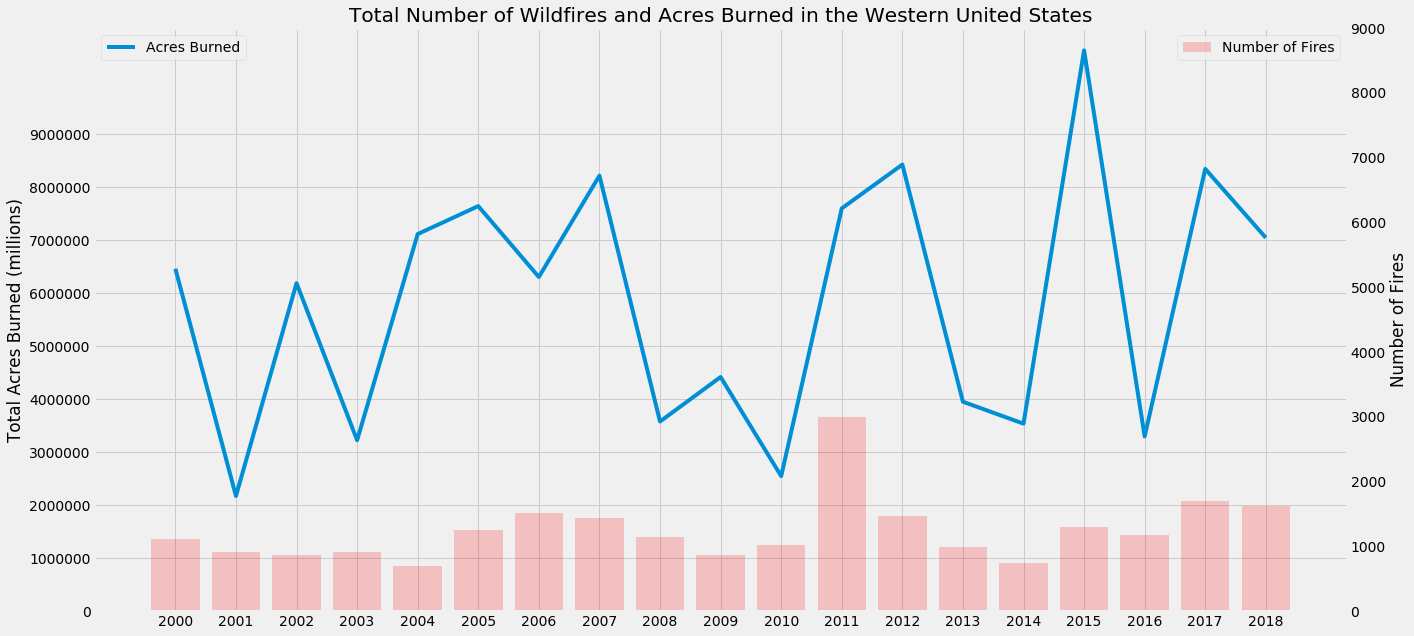

In [174]:

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

ax_2 = ax.twinx()

ax.plot(fire_acres, label = "Acres Burned")
ax.set_yticks(np.arange(0,10000000,1000000))

ax_2.bar(fire_count.index, fire_count, alpha = 0.2, color = 'red', label = "Number of Fires")
ax_2.set_yticks(np.arange(0, 10000, 1000))

ax_2.grid(b = False)

ax.set_title('Total Number of Wildfires and Acres Burned in the Western United States')
ax.set_ylabel('Total Acres Burned (millions)')
ax_2.set_ylabel('Number of Fires')

x_ticks = np.arange(2000, 2019, 1)
plt.xticks(x_ticks)

ax.legend(loc = "upper left")
ax_2.legend()
#plt.savefig("Wildfire_Trends.png")

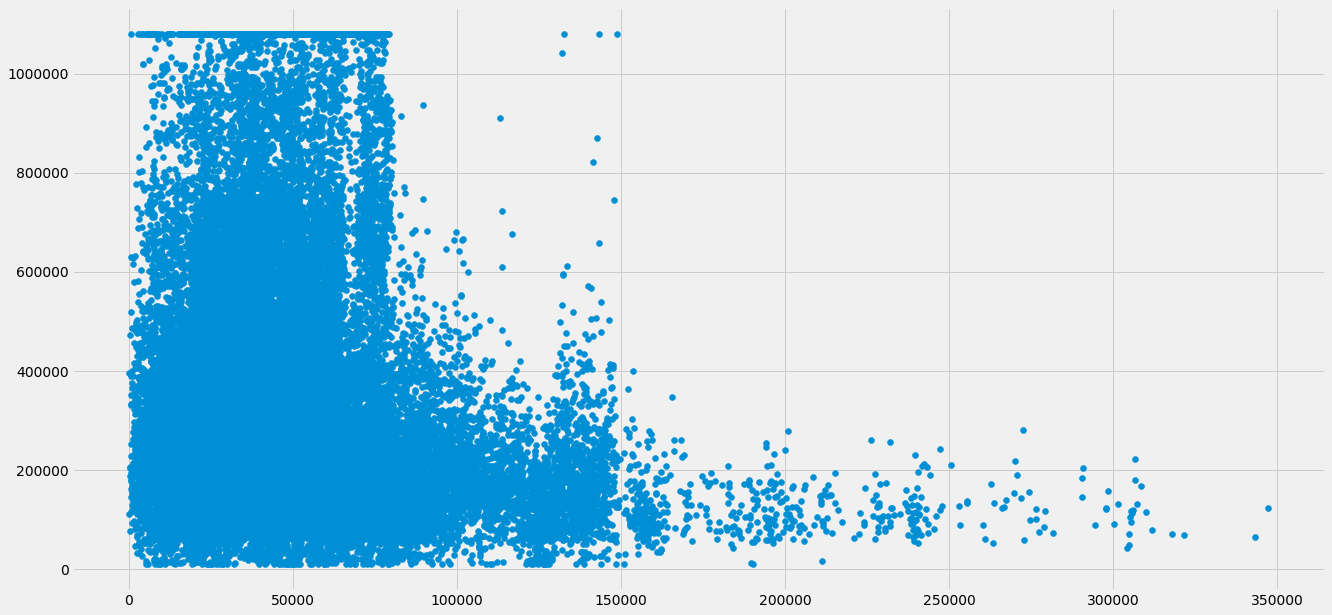

In [163]:
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

ax.scatter(ACS5_2010_2014["min_dist_2015"], ACS5_2010_2014["AL1HE001"] )



In [164]:
import seaborn as sns
from sklearn.neighbors import KernelDensity

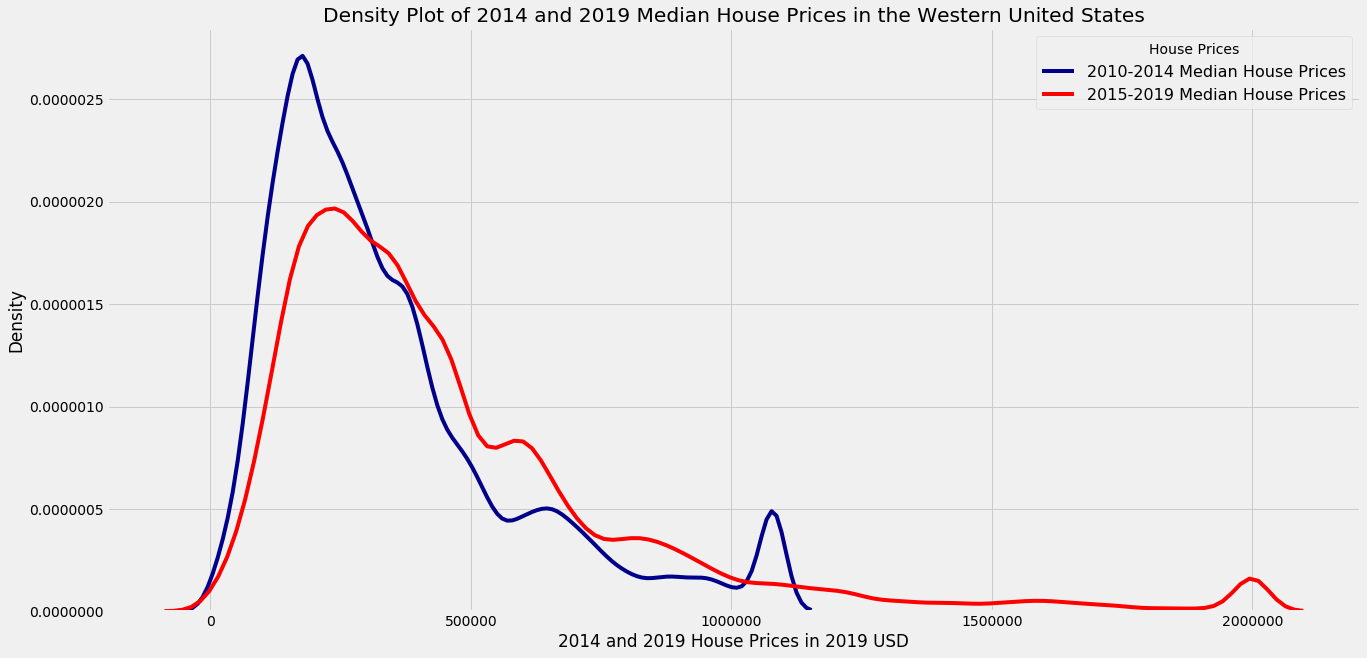

In [172]:
#density plot of house prices 2010-2014 versus 2015-2019
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
sns.distplot(ACS5_2010_2014["AL1HE001"], hist=False, kde=kde,
             bins=int(160/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label = "2010-2014 Median House Prices")

sns.distplot(ACS5_2015_2019["AL1HE001"], hist=False, kde=kde, 
             bins=int(160/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label = "2015-2019 Median House Prices")

plt.legend(prop={'size': 16}, title = 'House Prices')
plt.title('Density Plot of 2014 and 2019 Median House Prices in the Western United States')
plt.xlabel('2014 and 2019 House Prices in 2019 USD')
plt.ylabel('Density')
#plt.savefig("Density_Plot_House_Prices.png")

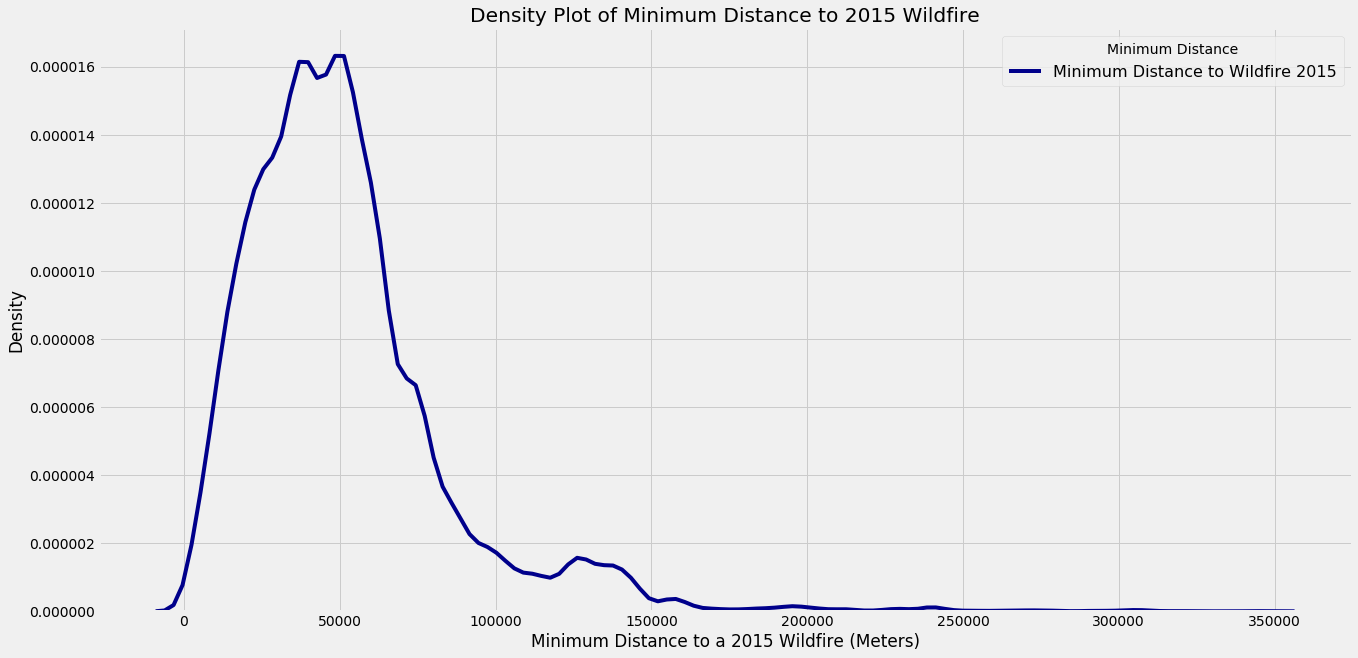

In [173]:
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
sns.distplot(ACS5_2010_2014["min_dist_2015"], hist=False, kde=kde,
             bins=int(160/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label = "Minimum Distance to Wildfire 2015")

plt.legend(prop={'size': 16}, title = 'Minimum Distance')
plt.title('Density Plot of Minimum Distance to 2015 Wildfire')
plt.xlabel('Minimum Distance to a 2015 Wildfire (Meters)')
plt.ylabel('Density')
#plt.savefig("Density_Min_Distance_Fire.png")

In [28]:
fire_state_count = wildfire_perimeters.groupby(["state"]).sum()

In [29]:
fire_state_count

,FID,fireyear,gisacres,SHAPE_Leng,SHAPE_Area,Count
state,,,,,,
AK,23576088,3958824,2.871246e+07,1268.710272,22.027516,1969
AL,1410404,342296,1.749262e+04,3.809471,0.006874,170
AR,1331757,423122,2.447536e+04,4.458535,0.009807,210
AS,4247,2014,3.842115e+03,0.177428,0.001509,1
AZ,12632793,2194116,4.515734e+06,178.168541,1.781682,1091
CA,63367026,9027184,1.378151e+07,590.035585,5.715556,4496
CO,10868981,1915432,1.795533e+06,126.154405,0.755100,953
CT,2646,2016,1.318450e+01,0.010840,0.000006,1
FL,3098414,702504,9.928664e+05,41.793148,0.368184,349


In [30]:
fire_state_count = fire_state_count[(fire_state_count.index == "CA") | (fire_state_count.index == "CO") | (fire_state_count.index == "AZ") | (fire_state_count.index == "ID") | (fire_state_count.index == "MT") | (fire_state_count.index == "NV") | (fire_state_count.index == "NM") | (fire_state_count.index == "OR")| (fire_state_count.index == "UT") | (fire_state_count.index == "WA") | (fire_state_count.index == "WY")| (fire_state_count.index == "NE")|(fire_state_count.index == "OK")| (fire_state_count.index == "SD")|(fire_state_count.index == "TX")|(fire_state_count.index == "KS")|(fire_state_count.index == "ND")]

In [31]:
fire_state_count

,FID,fireyear,gisacres,SHAPE_Leng,SHAPE_Area,Count
state,,,,,,
AZ,12632793,2194116,4.515734e+06,178.168541,1.781682,1091
CA,63367026,9027184,1.378151e+07,590.035585,5.715556,4496
CO,10868981,1915432,1.795533e+06,126.154405,0.755100,953
ID,40824729,6682281,1.278241e+07,620.664086,5.807122,3326
KS,30091,6047,6.852848e+03,0.797534,0.002847,3
MT,14705177,2623808,7.437857e+06,318.825226,3.534179,1305
ND,304261,48153,3.785696e+04,3.560022,0.017922,24
NE,342518,44145,3.692757e+05,11.332196,0.164351,22
NM,9147688,1601334,3.496169e+06,141.595738,1.377073,797


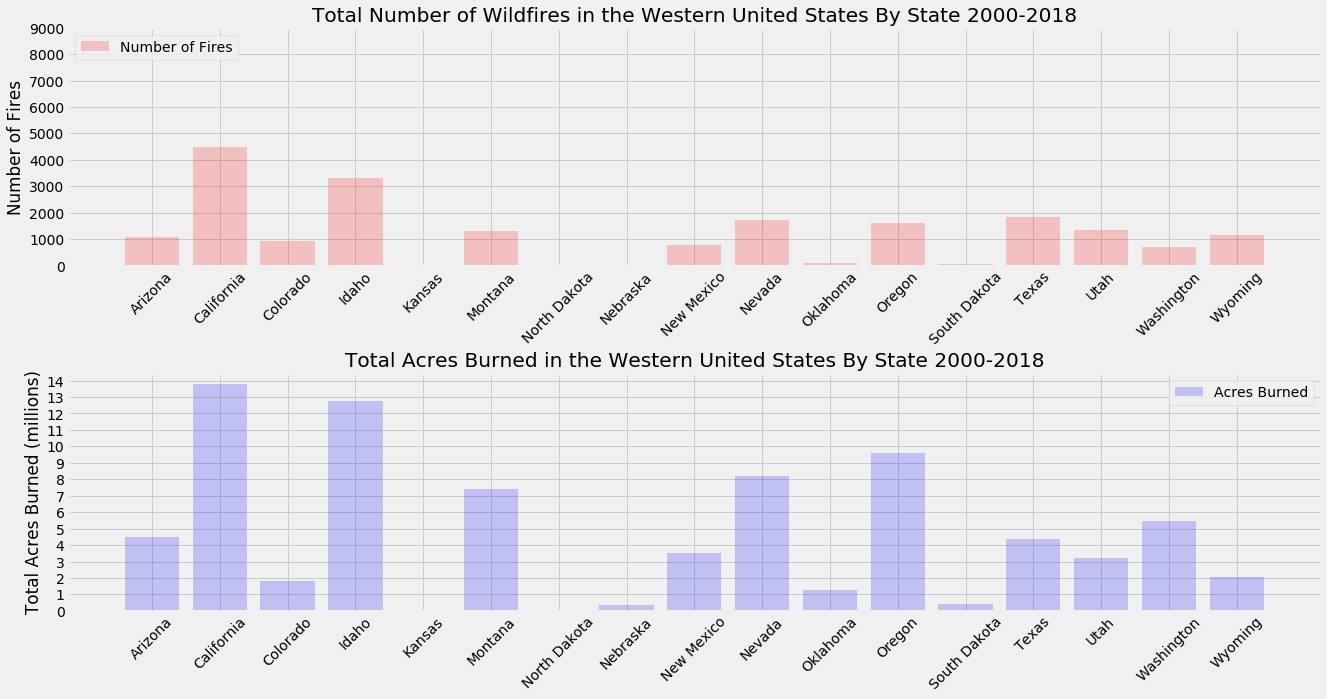

In [45]:
plt.rcParams['figure.figsize'] = (20,15)
plt.style.use('fivethirtyeight')

fig, (ax_1, ax_2) = plt.subplots(2,1, figsize = (20,10))

fig.subplots_adjust(hspace=0.45)

#ax_2 = ax.twinx()

# ax.bar(fire_state_count.index, fire_state_count["gisacres"], label = "Acres Burned")
# ax.set_yticks(np.arange(0,10000000,1000000))

ax_1.bar(fire_state_count.index, fire_state_count["Count"], alpha = 0.2, color = 'red', label = "Number of Fires")
ax_1.set_yticks(np.arange(0, 10000, 1000))
# x_ticks = np.arange(0, 24, 1)
# ax_2.set_xticks(x_ticks)


ax_2.bar(fire_state_count.index, fire_state_count["gisacres"], alpha = 0.2, color = 'blue', label = "Acres Burned")
ax_2.set_yticks(np.arange(0,15000000,1000000))
ax_2.set_yticklabels(list(range(0,16)))


ax_1.grid(b = True)

ax_1.set_title('Total Number of Wildfires in the Western United States By State 2000-2018')
ax_2.set_title('Total Acres Burned in the Western United States By State 2000-2018')
ax_2.set_ylabel('Total Acres Burned (millions)')
ax_1.set_ylabel('Number of Fires')

x_ticks = np.arange(0, 17, 1)
ax_1.set_xticks(x_ticks)
ax_1.set_xticklabels(["Arizona", "California", "Colorado","Idaho", "Kansas", "Montana", "North Dakota","Nebraska","New Mexico","Nevada","Oklahoma","Oregon","South Dakota","Texas","Utah", "Washington", "Wyoming"], rotation=45)
ax_2.set_xticklabels(["Arizona", "California", "Colorado","Idaho", "Kansas", "Montana", "North Dakota","Nebraska","New Mexico","Nevada","Oklahoma","Oregon","South Dakota","Texas","Utah", "Washington", "Wyoming"], rotation=45)

ax_1.legend(loc = "upper left")
ax_2.legend(loc = "upper right")
#plt.savefig('fire_by_state.png')
plt.savefig('fire_by_state.png', bbox_inches='tight')

In [ ]:
# fire_count = wildfire_perimeters.groupby(["fireyear"]).count()
# fire_acres = wildfire_perimeters.groupby(["fireyear"]).sum()

In [ ]:
# fire_count["weight_by_acres"] = (fire_count["Count"]*fire_acres["gisacres"])

In [ ]:
# fire_count

In [ ]:

# plt.rcParams['figure.figsize'] = (20,10)
# plt.style.use('fivethirtyeight')

# fig, ax = plt.subplots()

# #ax_2 = ax.twinx()

# ax.plot(fire_count.weight_by_acres, label = "Number of Fires Weighted By Acres")

# #ax_2.bar(fire_acres.index, fire_acres, alpha = 0.2, color = 'red', label = "Acres Burned")

# ax_2.grid(b = False)

# ax.set_title('Total Number of Wildfires and Acres Burned in the Western United States')
# ax.set_ylabel('Number of Fires Weighted By Acres')
# #ax_2.set_ylabel('Total Acres Burned')

# x_ticks = np.arange(2000, 2018, 1)
# plt.xticks(x_ticks)

# ax.legend(loc = "upper left")
# #ax_2.legend()


In [ ]:
# wildfire_perimeters_CA = wildfire_perimeters[wildfire_perimeters["state"]=="CA"]
# wildfire_perimeters_CA["Count"] = 1
# fire_count_CA = wildfire_perimeters_CA.groupby(["fireyear"]).count()
# fire_acres_CA = wildfire_perimeters_CA.groupby(["fireyear"]).sum()
# fire_count_CA = fire_count_CA["Count"]
# fire_acres_CA = fire_acres_CA["gisacres"]

# plt.rcParams['figure.figsize'] = (20,10)
# plt.style.use('fivethirtyeight')

# fig, ax = plt.subplots()

# ax_2 = ax.twinx()

# ax.plot(fire_count_CA, label = "Number of Fires")

# ax_2.bar(fire_acres_CA.index, fire_acres_CA, alpha = 0.2, color = 'red', label = "Acres Burned")

# ax_2.grid(b = False)

# ax.set_title('Total Number of Wildfires and Acres Burned in California')
# ax.set_ylabel('Number of Fires')
# ax_2.set_ylabel('Total Acres Burned')

# x_ticks = np.arange(2000, 2018, 1)
# plt.xticks(x_ticks)

# ax.legend(loc = "upper left")
# ax_2.legend()


In [185]:
3.450397e+05

345039.7

In [186]:
 4.556317e+05

455631.7

In [187]:
3.544493e+05

354449.3

In [188]:
5.770297e+05

577029.7

In [189]:
2.632294e+05

263229.4

In [190]:
 4.389570e+05

438957.0

In [191]:
(577029.7-438957)/438957

0.3145472107746316

In [192]:
(354449.3-263229.4)/263229.4

0.34654145775509865